In [1]:

#source EPOTFenv/bin/activate (launching and exiting the virtual environment containing the required modules, stored in the working directory)
#EPOTFenv/bin/python your_script.py - for running a script in the virtual environment
#source deactivate

#import all the libraries needed
from import_dep import *

# import my functions stored in the file 'functions' which can then be called with functions.function_name()
import functions



### Plotting and Output Variables 
plot_data = False # set to True to plot the data and export to path_out
powerpoint_data = False # set to True to export the data to a powerpoint presentation and export to path_out
fig_format = 'png' # format of the figure to be saved
plot_transparency = True # set to True to make the data plots transparent
ohm_m = 0 #set to 1 to force ohm-m units 0 to keep micro ohm cm units


##########TO DO LIST
# change so that if film_thickness == 1 all the functions output the sheet resistance
# and the plots show sheet resistance instead of resistivity
# including the output file names
# And an option for 2DEG so that it outputs 2d carrier density and mobility??

# True temperature not rounded temperature in the plots - for each field value - this will then highlight and temperature instability

# If temp<10 then 1dp, if greater than 10 then 0dp??

# check and sort the material title and plotstrings in a way that makes sense for multiple files - perhaps appending them together?



############## End User Defined Variables ##############


## Import Measurement Data 

In [2]:
all_directories = [] # list of all the directories containing the data
dat_raw = [] # list in which each item contains a list for each directory of all the files within it (list of lists)

### Data set 1
all_directories.append(Path('/Users/horatiocox/Desktop/RUG_Postdoc/Experiments/Electrical/VDP_JT029_SrRuO3/Data/'))
dat_raw.append(functions.import_ppms_data(all_directories[0], film_thickness = 14e-9, material = '$SrRuO_3$', plot_str = 'JT029_SrRuO3'))

### Data set 2
all_directories.append(Path('/Users/horatiocox/Desktop/RUG_Postdoc/Experiments/Electrical/VDP_HC003_LaScO3/Data/'))
dat_raw.append(functions.import_ppms_data(all_directories[1], film_thickness = 1, material = '$LaScO_3$', plot_str = 'HC003_LaScO3'))

### Data set 3
all_directories.append(Path('/Users/horatiocox/Desktop/RUG_Postdoc/Experiments/Electrical/VDP_YFW042_HZO/Data/'))
dat_raw.append(functions.import_ppms_data(all_directories[2], film_thickness = 1, material = '$HZO$', plot_str = 'YFW042_HZO'))
    
### Data set 4
all_directories.append(Path('/Users/horatiocox/Desktop/RUG_Postdoc/Experiments/Electrical/VDP_DR004_BSO_LSO/Data/'))
dat_raw.append(functions.import_ppms_data(all_directories[3], film_thickness = 1, material = '$BaSnO_3/LaScO_3$', plot_str = 'DR004_BSO'))
#BSO layer is 309 nm, LSO layer is 12.9 nm

### Data set 5
all_directories.append(Path('/Users/horatiocox/Desktop/RUG_Postdoc/Experiments/Electrical/VDP_DR003_BSO_LSO/Data/'))
dat_raw.append(functions.import_ppms_data(all_directories[4], film_thickness = 1, material = '$BaSnO_3/LaScO_3$', plot_str = 'DR003_BSO'))
#BSO layer is 317 nm, LSO layer is 12.7 nm

### Data set 6
all_directories.append(Path('/Users/horatiocox/Desktop/RUG_Postdoc/Experiments/Electrical/VDP_HC006_SSO/Data/'))
dat_raw.append(functions.import_ppms_data(all_directories[5], film_thickness = 1, material = '$LaSrSnO_3$', plot_str = 'HC006_SSO'))
#BSO layer is 317 nm, LSO layer is 12.7 nm

### Data set 7
all_directories.append(Path('/Users/horatiocox/Desktop/RUG_Postdoc/Experiments/Electrical/VDP_DR001_BSO_LSO/Data/'))
dat_raw.append(functions.import_ppms_data(all_directories[6], film_thickness = 1, material = '$BaSnO_3/LaScO_3$', plot_str = 'DR001_BSO'))
#BSO layer is 317 nm, LSO layer is 12.7 nm

### Data set 8
all_directories.append(Path('/Users/horatiocox/Desktop/RUG_Postdoc/Experiments/Electrical/VDP_YFW045_HZO/Data/'))
dat_raw.append(functions.import_ppms_data(all_directories[7], film_thickness = 1, material = '$HZO$', plot_str = 'YFW045_HZO'))

### Data set 9
all_directories.append(Path('/Users/horatiocox/Desktop/RUG_Postdoc/Experiments/Electrical/VDP_YFW044_HZO/Data/'))
dat_raw.append(functions.import_ppms_data(all_directories[8], film_thickness = 1, material = '$HZO$', plot_str = 'YFW044_HZO'))

### Data set 10
all_directories.append(Path('/Users/horatiocox/Desktop/RUG_Postdoc/Experiments/Electrical/VDP_YFW046_HZO/Data/'))
dat_raw.append(functions.import_ppms_data(all_directories[9], film_thickness = 1, material = '$HZO$', plot_str = 'YFW046_HZO'))

### Data set 11
all_directories.append(Path('/Users/horatiocox/Desktop/RUG_Postdoc/Experiments/Electrical/VDP_HC011_BSO_LSO_LaSSO_STO/Data/'))
dat_raw.append(functions.import_ppms_data(all_directories[10], film_thickness = 1, material = '$BaSnO_3/LaScO_3/LaSSO$', plot_str = 'HC011_BSO_LSO_LaSSO', V_inv = True))
# using V_inv = True to invert the voltage data for this set as the cables were reversed

### Data set 12
all_directories.append(Path('/Users/horatiocox/Desktop/RUG_Postdoc/Experiments/Electrical/VDP_HC013_LSO_BSO_LaSSO_STO/Data/'))
dat_raw.append(functions.import_ppms_data(all_directories[11], film_thickness = 1, material = '$LaScO_3/BaSnO_3/LaSSO$', plot_str = 'HC013_LSO_BSO_LaSSO'))

### Data set 13
all_directories.append(Path('/Users/horatiocox/Desktop/RUG_Postdoc/Experiments/Electrical/VDP_HC014_BSO_LSO_LaSSO_STO/Data/'))
dat_raw.append(functions.import_ppms_data(all_directories[12], film_thickness = 1, material = '$BaSnO_3/LaScO_3/LaSSO$', plot_str = 'HC014_BSO_LSO_LaSSO'))

### Data set 14
all_directories.append(Path('/Users/horatiocox/Desktop/RUG_Postdoc/Experiments/Electrical/VDP_DV127_WO3_YAO/Data/'))
dat_raw.append(functions.import_ppms_data(all_directories[13], film_thickness = 140e-9, material = '$WO_3/YAO$', plot_str = 'DV127_WO3_YAO'))

### Data set 15
all_directories.append(Path('/Users/horatiocox/Desktop/RUG_Postdoc/Experiments/Electrical/VDP_DR008a_BSO_LSO_STO/Data/'))
dat_raw.append(functions.import_ppms_data(all_directories[14], film_thickness = 1, material = '$BaSnO_3/LaScO_3/STO$', plot_str = 'DR008a_BSO_LSO'))

### Data set 16
all_directories.append(Path('/Users/horatiocox/Desktop/RUG_Postdoc/Experiments/Electrical/VDP_HC016_LSO_BSO_LaSSO_STO/Data/'))
dat_raw.append(functions.import_ppms_data(all_directories[15], film_thickness = 1, material = '$LaScO_3/BaSnO_3/LaSSO$', plot_str = 'HC016_LSO_BSO_LaSSO'))

### Data set 17
all_directories.append(Path('/Users/horatiocox/Desktop/RUG_Postdoc/Experiments/Electrical/VDP_HC015_LSO_BSO_STO/Data/'))
dat_raw.append(functions.import_ppms_data(all_directories[16], film_thickness = 1, material = '$LaScO_3/BaSnO_3$', plot_str = 'HC015_LSO_BSO_STO'))

### Data set 18
all_directories.append(Path('/Users/horatiocox/Desktop/RUG_Postdoc/Experiments/Electrical/VDP_DR009_BSO_LSO_STO/Data/'))
dat_raw.append(functions.import_ppms_data(all_directories[17], film_thickness = 1, material = '$LaScO_3/BaSnO_3$', plot_str = 'DR009_LSO_BSO_STO'))


### Data set 19
all_directories.append(Path('/Users/horatiocox/Desktop/RUG_Postdoc/Experiments/Electrical/VDP_DR010_BSO_LSO_STO/Data/'))
dat_raw.append(functions.import_ppms_data(all_directories[18], film_thickness = 1, material = '$LaScO_3/BaSnO_3$', plot_str = 'DR010_LSO_BSO_STO'))


### Data set 20
all_directories.append(Path('/Users/horatiocox/Desktop/RUG_Postdoc/Experiments/Electrical/VDP_DR012_LSO_BSO_BSO_STO/Data/'))
dat_raw.append(functions.import_ppms_data(all_directories[19], film_thickness = 1, material = '$LaScO_3/BaSnO_3/BaSnO_3$', plot_str = 'DR012_LSO_BSO_BSO_STO'))

### Data set 21
all_directories.append(Path('/Users/horatiocox/Desktop/RUG_Postdoc/Experiments/Electrical/VDP_JT082_BSO_BTO_SSTO_STO/Data/'))
dat_raw.append(functions.import_ppms_data(all_directories[20], film_thickness = 1, material = '$BaSnO_3/BaTiO_3/La_ySn_xSr_{1-x}TiO_3/STO$', plot_str = 'JT082_BSO_BTO_LaSSTO_STO'))

### Data set 22
all_directories.append(Path('/Users/horatiocox/Desktop/RUG_Postdoc/Experiments/Electrical/VDP_DR011_LSO_BSO_STO/Data/'))
dat_raw.append(functions.import_ppms_data(all_directories[21], film_thickness = 1, material = '$LaScO_3/BaSnO_3$', plot_str = 'DR011_LSO_BSO_STO'))








# Note that fields have been converted to Tesla

Error with file: .DS_Store, 'utf-8' codec can't decode byte 0x80 in position 3131: invalid start byte
File 2 imported: JT029_SrRuO3_silver_Combined with shape (650, 5, 6)
File 3 imported: JT029_SrRuO3_silver_Combined4 with shape (7920, 5, 6)
File 4 imported: JT029_SrRuO3_silver_Combined_fullrange.txt with shape (850, 5, 6)
File 5 imported: JT029_SrRuO3_silver_HallRun1 with shape (72, 5, 6)
File 6 imported: JT029_SrRuO3_silver_Halltest2 with shape (68, 5, 6)
Error with file: .DS_Store, 'utf-8' codec can't decode byte 0x80 in position 3131: invalid start byte
File 2 imported: HC003_BaSnO3_STO_061124_Hall with shape (3024, 5, 6)
Error with file: .DS_Store, 'utf-8' codec can't decode byte 0x80 in position 3131: invalid start byte
File 2 imported: YF042_HfO2_STO_nosilver_Hall_2 with shape (3660, 5, 6)
File 3 imported: YF042_HfO2_STO_silver_Hall_3 with shape (2970, 5, 6)
File 4 imported: YF042_HfO2_STO_silver_Hall_5 with shape (2508, 5, 6)
File 5 imported: YF042_HfO2_STO_silver_Hall_6 with s

## Instrument Applied Current Approximation
- Keep below this level to prevent joule heating based off the two terminal resistance

In [3]:

R_approx = (2e6)
a = (1000*R_approx)**(-0.5)
print(f'{a:.1e} A')

2.2e-05 A


## Select Data for Plotting ***********************************************

In [4]:
# First visualise the data contained in each list
for count, dat in enumerate(dat_raw):
    print(f'dat_{count}:', [f'{count_2}={d.filename}' for count_2, d in enumerate(dat)])


# Select the data sets to be plotted and put into a single list

#dat_raw_sel = [dat_raw[0][2], dat_raw[0][0], dat_raw[0][1]] # JT029
#dat_raw_sel = [dat_raw[20][0],dat_raw[20][4],dat_raw[20][5]] # JT082

#dat_raw_sel = [dat_raw[3][1]] # DR001
#dat_raw_sel = [dat_raw[4][5], dat_raw[4][7], dat_raw[4][9]] # , dat_raw[4][10], dat_raw[4][11],dat_raw[4][12]] # DR003
#dat_raw_sel = [dat_raw[3][0],dat_raw[3][1], dat_raw[3][2], dat_raw[3][3]] # DR004
#dat_raw_sel =  [dat_raw[14][2], dat_raw[14][1], dat_raw[14][4]] # DR008a
dat_raw_sel = [dat_raw[17][3]]#,dat_raw[17][2], dat_raw[17][1],  dat_raw[17][0],  dat_raw[17][4],  dat_raw[17][5] ] # DR009
#dat_raw_sel = [dat_raw[18][0], dat_raw[18][1],dat_raw[18][3] ] # DR010
#dat_raw_sel = [dat_raw[21][0],dat_raw[20][5]] # DR011
#dat_raw_sel = [ dat_raw[19][4], dat_raw[19][3], dat_raw[19][2], dat_raw[19][0]] # DR012
#dat_raw_sel = [ dat_raw[19][0], dat_raw[17][0] , dat_raw[18][1],dat_raw[18][3],dat_raw[18][0], dat_raw[14][1], dat_raw[14][4]] # DR Combined

#dat_raw_sel = [dat_raw[2][3] , dat_raw[2][2],  dat_raw[2][4], dat_raw[2][1]] # YFW042
#dat_raw_sel = [dat_raw[8][1], dat_raw[8][2]]    #,dat_raw[2][4],dat_raw[2][5]] YFW044
#dat_raw_sel = [ dat_raw[9][1], dat_raw[9][2], dat_raw[9][4]] #YFW046
#dat_raw_sel = [dat_raw[2][1], dat_raw[2][2], dat_raw[2][3], dat_raw[2][4], dat_raw[8][1], dat_raw[8][2], dat_raw[9][4]] # YFW Combined

#dat_raw_sel = dat_raw[1] # HC003
#dat_raw_sel = [dat_raw[10][0], dat_raw[10][4]] # HC011 ********* THE CURRENT IS INVERTED FOR THIS SAMPLE!!! **********
#dat_raw_sel = [dat_raw[11][0],dat_raw[11][4]] #,dat_raw[11][5]] # HC013
#dat_raw_sel = [dat_raw[12][3], dat_raw[12][0],dat_raw[12][1],dat_raw[12][2]] # HC014
#dat_raw_sel = [dat_raw[15][1], dat_raw[15][2]] #HC016
#dat_raw_sel = [dat_raw[16][1]]  #HC015
#dat_raw_sel = [dat_raw[15][1], dat_raw[11][0],dat_raw[11][4],dat_raw[10][0], dat_raw[10][4],dat_raw[16][1]] # HC Combined

# 2DEG combined
#dat_raw_sel = [dat_raw[20][0],dat_raw[18][1],dat_raw[18][3],dat_raw[18][0],dat_raw[17][0],dat_raw[10][0], dat_raw[10][4], dat_raw[4][7], dat_raw[2][4], dat_raw[2][1], dat_raw[8][1],dat_raw[9][4], dat_raw[11][0],dat_raw[11][4],dat_raw[14][1],dat_raw[16][1], dat_raw[15][1]] 


#dat_raw_sel = [dat_raw[13][5], dat_raw[13][2], dat_raw[13][3]] # DV127


print('dat_raw_sel:', [f'{count}={d.filename}' for count, d in enumerate(dat_raw_sel)])


dat_0: ['0=JT029_SrRuO3_silver_Combined', '1=JT029_SrRuO3_silver_Combined4', '2=JT029_SrRuO3_silver_Combined_fullrange.txt', '3=JT029_SrRuO3_silver_HallRun1', '4=JT029_SrRuO3_silver_Halltest2']
dat_1: ['0=HC003_BaSnO3_STO_061124_Hall']
dat_2: ['0=YF042_HfO2_STO_nosilver_Hall_2', '1=YF042_HfO2_STO_silver_Hall_3', '2=YF042_HfO2_STO_silver_Hall_5', '3=YF042_HfO2_STO_silver_Hall_6', '4=YF042_HfO2_STO_silver_Hall_7']
dat_3: ['0=DR001_LaScO3__BaSnO3_STO_201124_test1', '1=DR004_LaScO3__BaSnO3_STO_201124_combined3', '2=DR004_LaScO3__BaSnO3_STO_201124_combined4', '3=DR004_LaScO3__BaSnO3_STO_201124_combined5', '4=DR004_LaScO3__BaSnO3_STO_201124_combined6', '5=DR004_LaScO3__BaSnO3_STO_201124_test2']
dat_4: ['0=DR003_LaScO3__BaSnO3_STO_nosilver_combined1', '1=DR003_LaScO3__BaSnO3_STO_nosilver_combined2', '2=DR003_LaScO3__BaSnO3_STO_nosilver_test2', '3=DR003_LaScO3__BaSnO3_STO_nosilver_test3', '4=DR003_LaScO3__BaSnO3_STO_nosilver_test4', '5=DR003_LaScO3__BaSnO3_STO_silver_combined10', '6=DR003_LaSc

## ************************************************************************************************************************

## Extract and Check Temperature, Field, and Current values

In [5]:
# Extract the current, temperature and field values from the data as lists along with the number of values used for each
#ctf = [current_unique, temp_unique, field_unique, current_no, temp_no, field_no]
# Reduced_data = [1,-5] means that the first and last 5 temperature points are removed from the data
# Reduced_temp = [3,-1] will skip the first 3 temperature points and the last 1 temperature point
# Reduced_current = 2 will skip the first 2 current points and the last 2 current points
# extract_ctf(PPMS_files, reorder = 'double',  Reduced_temp = False, Reduced_current = False)
# set reorder = 'single' for data with new field configuration


dat = functions.extract_ctf(dat_raw_sel,Reduced_temp = False, Reduced_current=False,reorder = 'double')
# Check you have the expected and correct Temperature, Field and Current values!

# Update a single data file with reduced temperature or current values
#
#dat[0] = functions.extract_ctf([dat_raw_sel[0]], Reduced_temp = [0,-2], Reduced_current=False)[0]
#dat[3] = functions.extract_ctf([dat_raw_sel[3]], Reduced_temp = [0,-2], Reduced_current=False)[0]

# Scale all subseuquent plots for either sheet resistance or resistivity
# In case of 2DEG, you need sheet resistance 
if dat[0].film_thickness == 1:
    # No scaling for sheet resistance
    unit_scale = 1
    
elif ohm_m == 1: #specific case to force resistivity to be in ohm-m
    unit_scale = 1
    
else:
    # Convert resistivity from ohm-m to micro-ohm cm for better readability
    unit_scale = 1e8


For file: DR009_LaScO3__BaSnO3_STO_silver_6221_fixed_run13
9 Currents (uA): [-0.12 -0.09 -0.06 -0.03  0.    0.03  0.06  0.09  0.12]
8 Temperatures (K): [  2.  22.  42.  62.  82. 102. 122. 142.]
8 Fields (kOe): [ -0.  30.  60.  90.   0. -90. -60. -30.]
Is this correct?


## Colormaps

In [6]:
# Create Colormaps and Markers for the data based off the field and temperature values extracted
# Concatenate all d.ctf[1] and d.ctf[2] arrays
all_temps = np.concatenate([d.ctf[1] for d in dat])
all_fields = np.concatenate([d.ctf[2] for d in dat])

# Find the min and max values
min_temp = np.min(all_temps)
max_temp = np.max(all_temps)
min_field = np.min(all_fields)
max_field = np.max(all_fields)

print(f'min_temp={min_temp}, max_temp={max_temp}, min_field={min_field}, max_field={max_field}')
# Generating one set of colors for increasing positive field and one set for decreasing negative field

# Normalize the temperature and field values
norm_temp = Normalize(vmin=min_temp, vmax=max_temp)
norm_field = Normalize(vmin=min_field, vmax=max_field)

# Generate colormaps
cmap_temp = plt.get_cmap('coolwarm') 
cmap_field = plt.get_cmap('coolwarm')

# Example usage: get color for a specific temperature and field value
temp_value = 300  # Example temperature value
field_value = 1.5  # Example field value

color_temp = cmap_temp(norm_temp(temp_value))
color_field = cmap_field(norm_field(field_value))

print(f'Color for temperature {temp_value}: {color_temp}')
print(f'Color for field {field_value}: {color_field}')


# Generate color map for each data set
cmap_dat = plt.get_cmap('plasma')(np.linspace(0, 1, len(dat)))


# Generate a list of markers for the data
mark_p = ['+', 'x', '*', '^', 'v', '<', '>', 'p', 'P', 'o', 'h', 'H', 'X', 'd', 'D', '|', '_']

min_temp=2.0, max_temp=142.0, min_field=-8.9999492187, max_field=8.999958593699999
Color for temperature 300: (np.float64(0.705673158), np.float64(0.01555616), np.float64(0.150232812), np.float64(1.0))
Color for field 1.5: (np.float64(0.9383263563333333), np.float64(0.8089165520313726), np.float64(0.741161515027451), np.float64(1.0))


## Calculate VDP Resistivity, Magnetoresistance, Hall Coefficient and Hall Mobility


In [7]:
# Extract the resistivity using the VDP method and write to the PPMSData objects in the list "dat"
dat = functions.vdp_resistivity(dat, print_val = False, resistivity_guess = 0)

# Calculate the magnetoresistance at each temperature and field strength
# mag_res(temperature, field, index) where: index 0 = VDP config A, index 1 = VDP config B, index 2 = average of A and B
dat = functions.magnetoresistance(dat)

# Calculate the Hall coefficient and mobility
# hall_mobility(temperature, field, index) where: index 0 = VDP config A, index 1 = VDP config B, index 2 = average of A and B
dat = functions.vdp_hall(dat)


## Plot IV data to Check Linearity of Resitivity Measurements

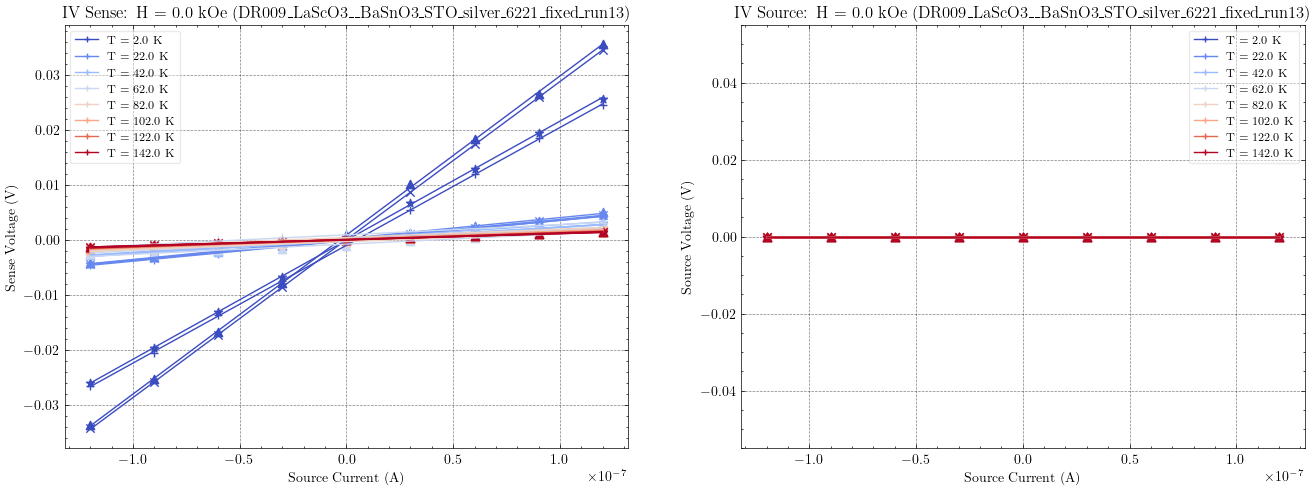

In [8]:
fig1 = plt.figure(figsize=(16, 5.5*len(dat)))
gs = fig1.add_gridspec(len(dat), 2)
labels = ['index_3', 'index_4', 'index_5', 'index_6']
color_s = ['r', 'g', 'b', 'm'] # simple four colors for the 4 configurations of vdp

for j, d in enumerate(dat):
    
    ax = fig1.add_subplot(gs[j, 0])
    ax1 = fig1.add_subplot(gs[j, 1])

    ## Plotting Source(I) vs Sense(V) data

    for t in range(d.ctf[4]):
        counter = int(t*d.ctf[3]*d.ctf[5]   + (d.ctf[5]*d.ctf[3]/2)) # to skip to the zero field data
        for i in range(4):  
            R_test = linregress(d.data_np[counter:d.ctf[3]+counter, 2, 2+i], d.data_np[counter:d.ctf[3]+counter, 4, 2+i])
            ax.scatter(d.data_np[counter:d.ctf[3]+counter, 2, 2+i], d.data_np[counter:d.ctf[3]+counter, 4, 2+i], color=cmap_temp(norm_temp(d.ctf[1][t])), marker=mark_p[i])
            ax.plot(d.data_np[counter:d.ctf[3]+counter, 2, 2+i], R_test.intercept + R_test.slope * d.data_np[counter:d.ctf[3]+counter, 2, 2+i], color=cmap_temp(norm_temp(d.ctf[1][t])))
        
        # Add a dummy plot for the legend entry
        ax.plot([], [], marker = mark_p[j], color=cmap_temp(norm_temp(d.ctf[1][t])), label=f'T = {d.ctf[1][t]} K')
        
        ax.legend(loc='best', fontsize='small', markerscale=0.8, framealpha=0.4)

    # Set labels and title
    ax.set_xlabel('Source Current (A)')
    ax.set_ylabel('Sense Voltage (V)')
    ax.set_title(f'IV Sense: H = {np.round(d.data_np[counter, 1, 2],decimals=0)*10} kOe ({d.filename})')


    ## Plotting the Source IV data
    for t in range(d.ctf[4]):
        counter = int(t*d.ctf[3]*d.ctf[5]  + (d.ctf[5]*d.ctf[3]/2)) # to skip to the zero field data
        for i in range(4):  
            R_test_2 = linregress(d.data_np[counter:d.ctf[3]+counter, 2, 2+i], d.data_np[counter:d.ctf[3]+counter, 3, 2+i])
            ax1.scatter(d.data_np[counter:d.ctf[3]+counter, 2, 2+i], d.data_np[counter:d.ctf[3]+counter, 3, 2+i], color=cmap_temp(norm_temp(d.ctf[1][t])), marker=mark_p[i])
            ax1.plot(d.data_np[counter:d.ctf[3]+counter, 2, 2+i], R_test_2.intercept + R_test_2.slope * d.data_np[counter:d.ctf[3]+counter, 2, 2+i], color=cmap_temp(norm_temp(d.ctf[1][t])))
        #print(f'T = {d.ctf[1][t]} K')
        #print(f'T_true = {d.data_np[counter, 0, 2+i]} K')
        # Add a dummy plot for the legend entry
        ax1.plot([], [], marker = mark_p[j], color=cmap_temp(norm_temp(d.ctf[1][t])), label=f'T = {d.ctf[1][t]} K')
        
        ax1.legend(loc='best', fontsize='small', markerscale=0.8, framealpha=0.4)

    # Set labels and title
    ax1.set_xlabel('Source Current (A)')
    ax1.set_ylabel('Source Voltage (V)')
    ax1.set_title(f'IV Source: H = {np.round(d.data_np[counter, 1, 2],decimals=0)*10} kOe ({d.filename})')

    #ax.set_ylim(-1e-3,1e-3)
    #ax.set_ylim(4e-4,6e-4)

plt.show()
if plot_data == True:
    fig1.savefig(dat[0].directory.joinpath(f'{dat[0].plot_str}_IV_resistivity.{fig_format}'), dpi=300, bbox_inches='tight', transparent=plot_transparency)


## R-squared Analysis to Check Linearity of I-V data

average R-squared for DR009_LaScO3__BaSnO3_STO_silver_6221_fixed_run13 = 0.9983172731456649


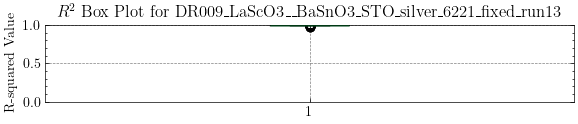

In [9]:
fig2 = plt.figure(figsize=(15, 3*len(dat) // 2))
gs = fig2.add_gridspec(1+len(dat) // 2, 2)

for j, d in enumerate(dat):
    #for i in range(len(d.R_squared_res)):
        #print(f'{d.filename}T={d.ctf[1][i//4]}, config = {i %4 } R-squared = {d.R_squared_res[i]}') - only works for zero field at the moment
    
    
    print(f'average R-squared for {d.filename} =', sum(d.R_squared_res) / len(d.R_squared_res))
    ax = fig2.add_subplot(gs[j // 2, j % 2])
    
    # Plot R-square values in a boxplot
    # Note that the y axis is showing the deviation in 1e-6 from the perfect value of 1 so generally the values are very close to 1
    ax.boxplot(d.R_squared_res)
    ax.set_title(f'$R^2$ Box Plot for {d.filename}')
    ax.set_ylabel('R-squared Value')
    ax.set_ylim(0, 1)  # If needed, you can set x-axis limits too

plt.show()

if plot_data == True:
    fig2.savefig(dat[0].directory.joinpath(f'{dat[0].plot_str}_IV_Rsq_boxplot.{fig_format}'), dpi=300, bbox_inches='tight', transparent=plot_transparency)

## Resistivity Configuration Compararison 
Comparing the resistivity in configuration A and B which are inverted versions of one another (e.g. source meter and sense meter swapped positions)
This is a good check for any systematic errors

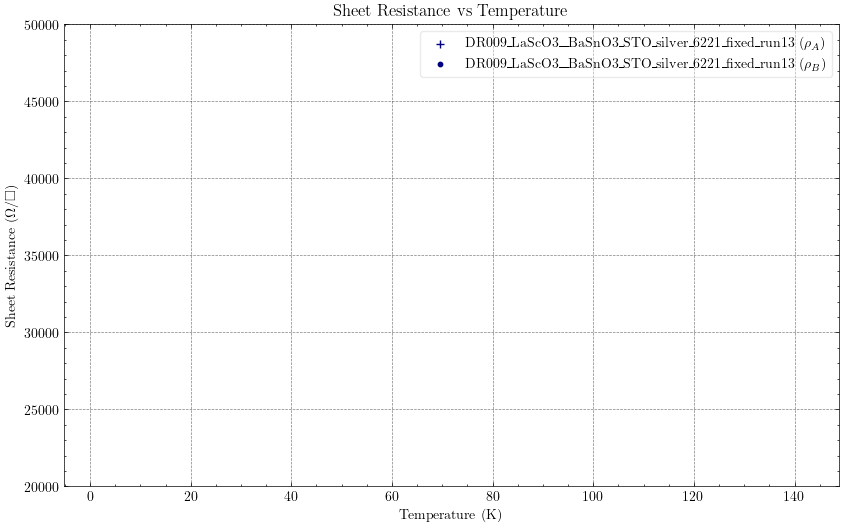

In [10]:
# Create a figure and axis
fig3 = plt.figure(figsize=(10, 6))
ax = fig3.add_subplot(111)  # Create a single subplot

c_val = plt.cm.jet(np.linspace(0,1,len(dat)))


# Loop over the data sets
for j, d in enumerate(dat):
    
    # Plot R_sheet_A vs Temp
    ax.scatter(d.res_data[:,0], d.res_data[:,2] * unit_scale, marker='+', color=c_val[j], label=f'{d.filename} ($\\rho_A$)')

    # Plot R_sheet_B vs Temp
    ax.scatter(d.res_data[:,0], d.res_data[:,3] * unit_scale, marker='o', s=10, color=c_val[j], label=f'{d.filename} ($\\rho_B$)')

# Set labels and title for either sheet resistance or resistivity
ax.set_xlabel('Temperature (K)')
if dat[0].film_thickness == 1:
    ax.set_ylabel(r'Sheet Resistance ($\Omega/\square$)')
    ax.set_title(r'Sheet Resistance vs Temperature')
    
elif ohm_m == 1:
    ax.set_ylabel(r'Resistivity ($\Omega \cdot$m)')
    ax.set_title(r'Resistivity vs Temperature')
    
else:
    ax.set_ylabel(r'Resistivity ($\mu \Omega \cdot$cm)')
    ax.set_title(r'Resistivity vs Temperature')

# Add a grid
ax.grid(True)

# Add a legend
ax.legend(loc='best', framealpha=0.4)

#ax.set_yscale('log')
ax.set_ylim(2e4, 5e4)
#ax.set_xlim(0, 330)
# Show the plot
plt.show()

if plot_data == True:
    fig3.savefig(dat[0].directory.joinpath(f'{dat[0].plot_str}_rho_xx_A_vs_B.{fig_format}'), dpi=300, bbox_inches='tight', transparent=plot_transparency)


## Resistivity vs Temperature

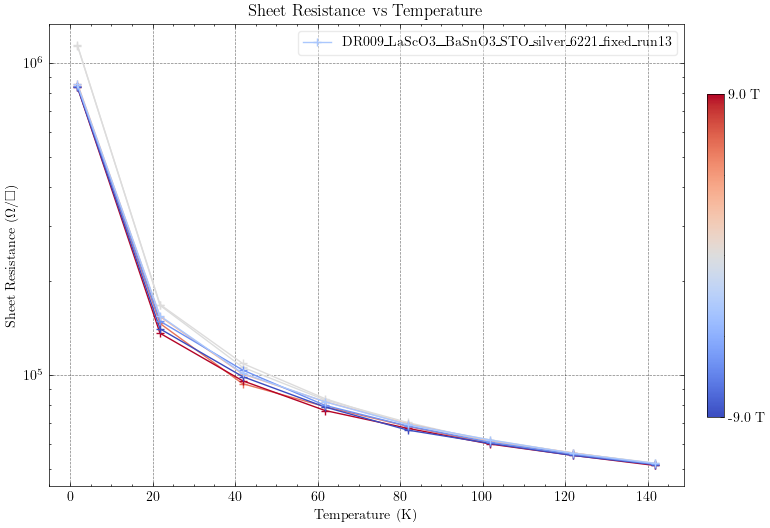

In [11]:
# Create a figure and axis
fig4 = plt.figure(figsize=(10, 6))
ax = fig4.add_subplot(111)  # Create a single subplot


# Loop over the data sets
for j, d in enumerate(dat):
    for k in  range(d.ctf[5]): ### [int(d.ctf[5]/2)]: # # # #
        # Plot rho_film vs Temp
        ax.plot(d.res_data[k::d.ctf[5], 0], d.res_data[k::d.ctf[5], 4] * unit_scale, marker=mark_p[j], color=cmap_field(norm_field(d.res_data[k, 1])))

    # Add a dummy plot for the legend entry
    ax.plot([], [], marker = mark_p[j], color=cmap_field(norm_field(d.res_data[k, 1])), label=f'{d.filename}')
    
    # Create a DataFrame with the x and y data
    #df = pd.DataFrame({'Temperature (K)': d.res_data[k::d.ctf[5], 0], 'Resistivity': d.res_data[k::d.ctf[5], 4] * unit_scale})

    # Write the DataFrame to an Excel file
    #df.to_excel(f'{d.filename}_data.xlsx', index=False)

# Set labels and title for either sheet resistance or resistivity
ax.set_xlabel('Temperature (K)')
if dat[0].film_thickness == 1:
    ax.set_ylabel(r'Sheet Resistance ($\Omega/\square$)')
    ax.set_title(f'Sheet Resistance vs Temperature')
    
elif ohm_m == 1:
    ax.set_ylabel(r'Resistivity ($\Omega \cdot$m)')
    ax.set_title('Resistivity vs Temperature')
    
else:
    ax.set_ylabel(r'Resistivity ($\mu \Omega \cdot$cm)')
    ax.set_title('Resistivity vs Temperature')

# Add a grid
ax.grid(True)

# Add a legend
ax.legend(loc='best', framealpha=0.4)

# Create a ScalarMappable and add a colorbar
sm = ScalarMappable(cmap=cmap_field, norm=norm_field)
cbar = plt.colorbar(sm, ax=ax,  pad=0.03, shrink=0.7)
cbar.set_ticks([min_field, max_field])
cbar.set_ticklabels([f'{min_field:.1f} T', f'{max_field:.1f} T'])

#ax.set_xlim(0,0.3)
#ax.set_ylim(1e5, 4e6)
#ax.set_ylim(136.4, 137)
ax.set_yscale('log')

# Show the plot
plt.show()

if plot_data == True:
    fig4.savefig(dat[0].directory.joinpath(f'{dat[0].plot_str}_rho_xx_vs_temperature.{fig_format}'), dpi=300, bbox_inches='tight', transparent=plot_transparency)


- Anderson localisation causes the metal insulator transition at low T
- If you have defects in film, they can have an external effect of localising charge carriers and reducing the conductivity
    - Also causes loss of metalicity beneath a certain thicknes of LSMO etc
    -  Defects localise the previously delocalised charge carriers, either due to thickness reudction or low T
    - Low thicknes its because number of defects is constant - > higher defect density
    

## Data Filtering on Resistivity Data
- There appear to be outliers where an error is thrown
- This is confirmed by repeat experiments where the spikes in resistivity are not consistent

In [12]:
## Median Filter
filt_kern = 0
if filt_kern != 0:
    for j, d in enumerate(dat):
        for t_count, t in enumerate(d.ctf[1], start=0):  
            
            # Filter the resistivity data    
            res_dat = d.res_data[t_count*d.ctf[5]:(t_count+1)*d.ctf[5], 4]
            res_dat_filtered = scipy.signal.medfilt(res_dat, kernel_size=filt_kern)
            d.res_data[t_count*d.ctf[5]:(t_count+1)*d.ctf[5], 4] = res_dat_filtered

            # Filter the Hall data
            index = t_count * d.ctf[5]
            hall_dat = d.hall_data[index:index+d.ctf[5], 6]
            hall_dat_filtered = scipy.signal.medfilt(hall_dat, kernel_size=filt_kern)
            d.hall_data[index:index+d.ctf[5], 6] = hall_dat_filtered
    
    
    # Re-calculate the magnetoresistance after filtering (exclude_res makes sure it doesn't recalculate the resistivity and overwrite the filtering)      
    dat = functions.magnetoresistance(dat, exclude_res=True)
    
## Gaussian Smoothing Filter
filt_sigma = 0
if filt_sigma != 0:
    for j, d in enumerate(dat):
        for t_count, t in enumerate(d.ctf[1], start=0):   
            
            # Filter the resistivity data      
            res_dat = d.res_data[t_count*d.ctf[5]:(t_count+1)*d.ctf[5], 4]
            res_dat_smoothed = scipy.ndimage.gaussian_filter1d(res_dat, sigma=filt_sigma)
            d.res_data[t_count*d.ctf[5]:(t_count+1)*d.ctf[5], 4] = res_dat_smoothed
            
            # Filter the Hall data
            index = t_count * d.ctf[5]
            hall_dat = d.hall_data[index:index+d.ctf[5], 6]
            hall_dat_smoothed = scipy.ndimage.gaussian_filter1d(hall_dat,  sigma=filt_sigma)
            d.hall_data[index:index+d.ctf[5], 6] = hall_dat_smoothed
    
    
    # Re-calculate the magnetoresistance after smoothing (exclude_res makes sure it doesn't recalculate the resistivity and overwrite the smoothing)      
    dat = functions.magnetoresistance(dat, exclude_res=True)

## Z-score outlier detection
threshold = 0  # Z-score threshold for detecting outliers (lower threshold means more points are considered outliers (2 is typical value))
if threshold != 0:
    for j, d in enumerate(dat):
        for t_count, t in enumerate(d.ctf[1], start=0):      
            res_dat = d.res_data[t_count*d.ctf[5]:(t_count+1)*d.ctf[5], 4]
            
            # Calculate the Z-scores of the data
            z_scores = zscore(res_dat)
            
            # Identify outliers
            outliers = np.abs(z_scores) > threshold
            
            # Replace outliers with interpolated values
            res_dat_filtered = res_dat.copy()
            res_dat_filtered[outliers] = np.interp(np.flatnonzero(outliers), np.flatnonzero(~outliers), res_dat[~outliers])
            
            d.res_data[t_count*d.ctf[5]:(t_count+1)*d.ctf[5], 4] = res_dat_filtered
    
    # Re-calculate the magnetoresistance after filtering (exclude_res makes sure it doesn't recalculate the resistivity and overwrite the filtering)      
    dat = functions.magnetoresistance(dat, exclude_res=True)

## Resistivity vs H

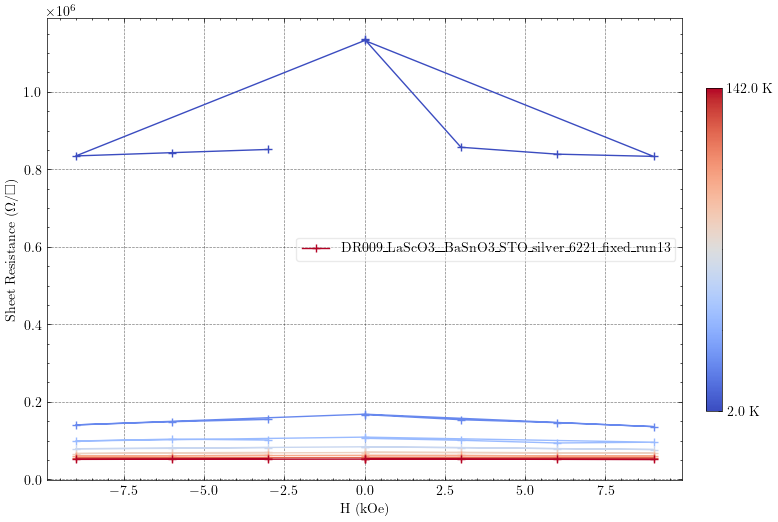

In [13]:
fig5 = plt.figure(figsize=(10, 6 ))
gs = fig5.add_gridspec(1, 1)
ax = fig5.add_subplot(gs[0, 0])


for j, d in enumerate(dat):
    for t_count, t in enumerate(d.ctf[1], start=0):      
            
            ax.plot(d.res_data[t_count*d.ctf[5]:(t_count+1)*d.ctf[5], 1], d.res_data[t_count*d.ctf[5]:(t_count+1)*d.ctf[5], 4] * unit_scale, marker=mark_p[j], color=cmap_temp(norm_temp(t)))
            #ax.plot(d.res_data[t_count*d.ctf[5]:(t_count+1)*d.ctf[5], 1], d.res_data[t_count*d.ctf[5]:(t_count+1)*d.ctf[5], 3] * unit_scale, marker=mark_p[j], color=cmap_temp(norm_temp(t)), linestyle=':')
    # Add a dummy plot for the legend entry
    ax.plot([], [], marker = mark_p[j], color=cmap_temp(norm_temp(t)), label=f'{d.filename}')
        

# Set labels and title for either sheet resistance or resistivity
ax.set_xlabel('H (kOe)')   
if dat[0].film_thickness == 1:
    ax.set_ylabel(r'Sheet Resistance ($\Omega/\square$)')
elif ohm_m == 1:
    ax.set_ylabel(r'Resistivity ($\Omega \cdot$m)')
    ax.set_title(r'Resistivity vs Field')
else:
    ax.set_ylabel(r'Resistivity ($\mu \Omega \cdot$cm)')
    ax.set_title(r'Resistivity vs Field')

ax.legend(loc='best', framealpha=0.4)

# Create a ScalarMappable and add a colorbar
sm = ScalarMappable(cmap=cmap_temp, norm=norm_temp)
cbar = plt.colorbar(sm, ax=ax,  pad=0.03, shrink=0.7)
#cbar.set_label('Temperature (K)')
cbar.set_ticks([min_temp, max_temp])
cbar.set_ticklabels([f'{min_temp:.1f} K', f'{max_temp:.1f} K'])

#ax.set_xlim(-0.0001, 0.0001)

plt.show()

if plot_data == True:
    fig5.savefig(dat[0].directory.joinpath(f'{dat[0].plot_str}_resistivity_vs_field.{fig_format}'), dpi=300, bbox_inches='tight', transparent=plot_transparency)


## Magnetoresistance vs H
- Plotting the magnetoresistance vs the Applied field strength (H) for several temperatures

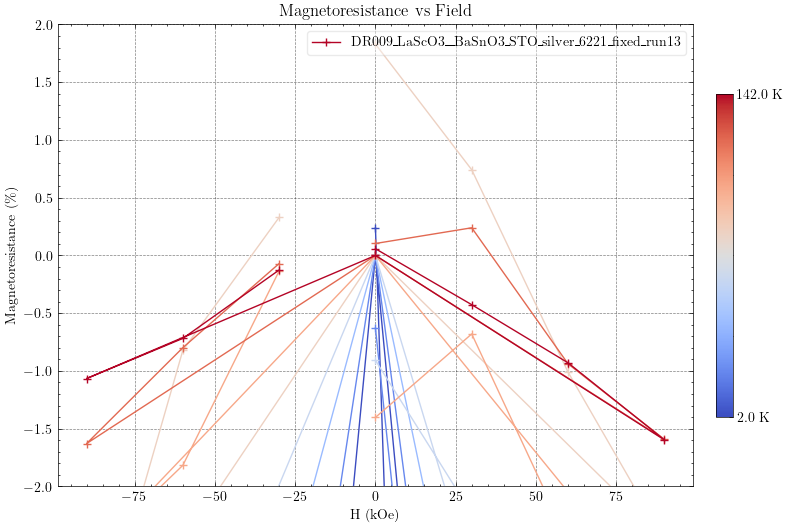

In [14]:
fig6 = plt.figure(figsize=(10, 6 ))
gs = fig6.add_gridspec(1, 1)
ax = fig6.add_subplot(gs[0, 0])

for j, d in enumerate(dat):
    for t_count, t in enumerate(d.ctf[1], start=0):  
            # Add a plot of magnetoresistance vs field strength for each loop of temperature (excluding last field point which is repeat of B=0)
            ax.plot(d.tf_av[t_count*d.ctf[5]:(t_count+1)*d.ctf[5],1] * 10, d.mag_res[t_count, :, 2], marker=mark_p[j], color=cmap_temp(norm_temp(t)))
            #ax.plot(d.ctf[2][:] * 10, d.mag_res[t_count, :, 1]-d.mag_res[t_count, :, 0], marker=mark_p[j], color=cmap_temp(norm_temp(t)), linestyle=':')
            # Plot repeat point of B=0 with an x marker to show the difference between two B=0 points
            # ax.scatter(d.ctf[2][int(d.ctf[5] / 2)] * 10, d.mag_res[t_count, int(d.ctf[5] / 2), 2], marker='x', color=c_val[t_count])
    # Add a dummy plot for the legend entry
    ax.plot([], [], marker = mark_p[j], color=cmap_temp(norm_temp(t)), label=f'{d.filename}')
    #ax.plot([], [], marker = mark_p[j], color=cmap_temp(norm_temp(t)), label=f'{d.filename}(configA-configB)', linestyle=':')
        
ax.set_xlabel('H (kOe)')
ax.set_ylabel(r'Magnetoresistance (\%)')
ax.set_title(f'Magnetoresistance vs Field')
ax.legend(loc='best', framealpha=0.4)

# Create a ScalarMappable and add a colorbar
sm = ScalarMappable(cmap=cmap_temp, norm=norm_temp)
cbar = plt.colorbar(sm, ax=ax,  pad=0.03, shrink=0.7)
#cbar.set_label('Temperature (K)')
cbar.set_ticks([min_temp, max_temp])
cbar.set_ticklabels([f'{min_temp:.1f} K', f'{max_temp:.1f} K'])

ax.set_ylim(-2, 2)

plt.show()

if plot_data == True:
    fig6.savefig(dat[0].directory.joinpath(f'{dat[0].plot_str}_magnetoresistance_vs_field.{fig_format}'), dpi=300, bbox_inches='tight', transparent=plot_transparency)


- The longitudinal resistance exhibits a rapid decrease, attributed to weak localization (WL), a phenomenon commonly observed in  disordered semiconductor systems
- The magnetoresistance (MR) exhibited a parabolic behavior within the intermediate magnetic field range (1.5T to 4T), as illustrated in Figure 5(b). Concurrently, at the fields where SdH oscillations emerge, it indicates the onset of quantum effects that dominate over the classical parabolic behavior.

## Magnetoresistance Vs T
- Now looking at how the Magnetoresitance at a set field strength varies over temperature
- Displaying this for VDP configuration A, VDP configuration B and the average of the two

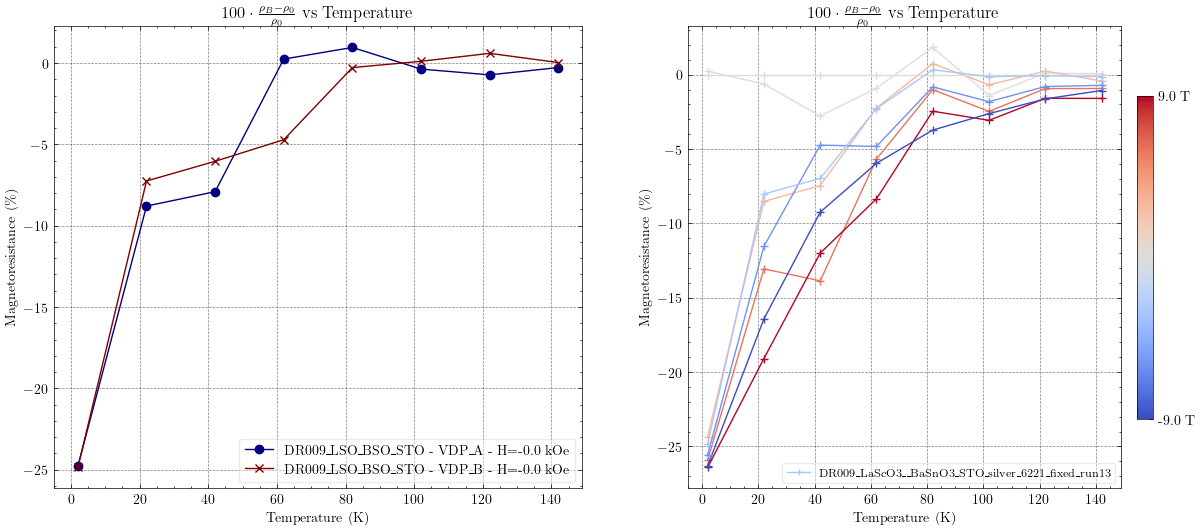

In [15]:
fig7 = plt.figure(figsize=(15, 6))
ax = fig7.add_subplot(121)  # Create two subplots
ax2 = fig7.add_subplot(122)  

# Generating one set of colors for increasing positive field and one set for decreasing negative field
# higher field is brighter color in both cases
cmap1 = plt.get_cmap('jet')(np.linspace(0, 1, int(dat[0].ctf[5] / 2)))
cmap2 = plt.get_cmap('jet_r')(np.linspace(0, 1, int(dat[0].ctf[5] / 2)))
c_val = np.vstack((cmap1, cmap2))





# Sub_plot 1: Comparing configurations A and B
for d in dat:
    # Find the index of the maximum positive field strength
    f_index = int(d.ctf[5]) - 1
    ax.plot(d.ctf[1], d.mag_res[:, f_index, 0], marker='o', color=c_val[0], label=f'{d.plot_str} - VDP_A - H={np.round(d.ctf[2][f_index]/1000, 0)} kOe')
    ax.plot(d.ctf[1], d.mag_res[:, f_index, 1], marker='x', color=c_val[int(len(c_val)/2)], label=f'{d.plot_str} - VDP_B - H={np.round(d.ctf[2][f_index]/1000, 0)} kOe')

ax.set_xlabel('Temperature (K)')
ax.set_ylabel(r'Magnetoresistance (\%)')
ax.set_title(r'$100 \cdot \frac{\rho_{B} - \rho_{0}}{\rho_{0}}$ vs Temperature')
ax.legend(loc='best', framealpha=0.4)

# Sub_plot 2: Comparing the average magnetoresistance vs T for various field strengths 
for j, d in enumerate(dat):

    # Generating one set of colors for increasing positive field and one set for decreasing negative field
    cmap1 = plt.get_cmap('jet')(np.linspace(0, 1, int(d.ctf[5] / 2)))
    cmap2 = plt.get_cmap('jet_r')(np.linspace(0, 1, int(d.ctf[5] / 2)))
    c_val = np.vstack((cmap1, cmap2))
    
    for H_count, H in enumerate(d.ctf[2], start=0):
        ax2.plot(d.ctf[1], d.mag_res[:, H_count, 2], marker=mark_p[j], color=cmap_field(norm_field(H)))     
    
    # Add a dummy plot for the legend entry
    ax2.plot([], [], marker = mark_p[j], color = cmap_field(norm_field(H)), label=f'{d.filename}')
        
ax2.set_xlabel('Temperature (K)')
ax2.set_ylabel(r'Magnetoresistance (\%)')
ax2.set_title(r'$100 \cdot \frac{\rho_{B} - \rho_{0}}{\rho_{0}}$ vs Temperature')
# Add a legend outside the plot
ax2.legend(loc='lower right', fontsize='small', markerscale=0.8, framealpha=0.4)

#ax2.set_ylim(-10, 100)
#ax2.set_xlim(0, 50)

# Create a ScalarMappable and add a colorbar
sm = ScalarMappable(cmap=cmap_field, norm=norm_field)
cbar = plt.colorbar(sm, ax=ax2,  pad=0.03, shrink=0.7)
cbar.set_ticks([min_field, max_field])
cbar.set_ticklabels([f'{min_field:.1f} T', f'{max_field:.1f} T'])


plt.show()

if plot_data == True:
    fig7.savefig(dat[0].directory.joinpath(f'{dat[0].plot_str}_magnetoresistance_vs_temperature.{fig_format}'), dpi=300, bbox_inches='tight', transparent=plot_transparency)


## Arhenius Plot

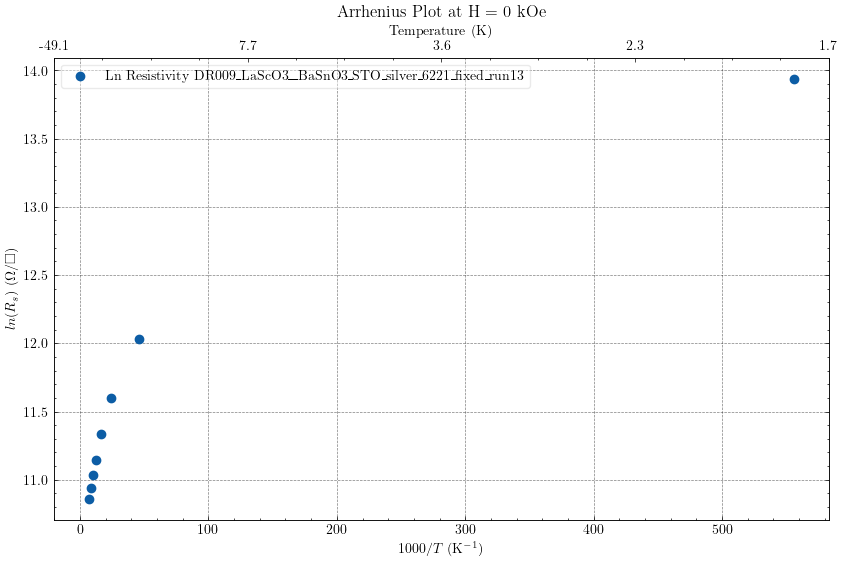

In [16]:
# Create a figure and axis
fig8 = plt.figure(figsize=(10, 6))
ax = fig8.add_subplot(111)  # Create a single subplot

# Loop over the data sets
for j, d in enumerate(dat):
    # Plot rho_film vs 1000/Temp
    ax.scatter(1000 / d.res_data[int(d.ctf[5]/2)::d.ctf[5], 0], np.log(d.res_data[int(d.ctf[5]/2)::d.ctf[5], 4]), marker='o', linestyle='-', label=f'Ln Resistivity {d.filename}')


# Set labels and title for either sheet resistance or resistivity
ax.set_xlabel(r'$1000/T$ (K$^{-1}$)')
ax.set_title(r'Arrhenius Plot at H = 0 kOe')
if dat[0].film_thickness == 1:
    ax.set_ylabel(r'$ln(R_s)$ ($\Omega/\square$)')
else:
    ax.set_ylabel(r'$\ln(\rho)$ ($\Omega \cdot m$)')


# Add a grid
ax.grid(True)

# Add a legend
ax.legend(loc='best', framealpha=0.4)

# Create a secondary x-axis at the top
ax2 = ax.twiny()

# Set the limits of the secondary x-axis to match the primary x-axis
ax2.set_xlim(ax.get_xlim())

# Set the ticks and labels for the secondary x-axis
new_ticks = np.linspace(ax.get_xlim()[0], ax.get_xlim()[1], num=5)
ax2.set_xticks(new_ticks)
ax2.set_xticklabels([f'{1000/tick:.1f}' for tick in new_ticks])
ax2.set_xlabel('Temperature (K)')
# Disable grid lines for the secondary x-axis
ax2.grid(False)

#ax.set_xlim(0, 300)

# Show the plot
plt.show()

if plot_data == True:
    fig8.savefig(dat[0].directory.joinpath(f'{dat[0].plot_str}_Arrhenius Plot.{fig_format}'), dpi=300, bbox_inches='tight', transparent=plot_transparency)

## Log(R) vs Log(T)

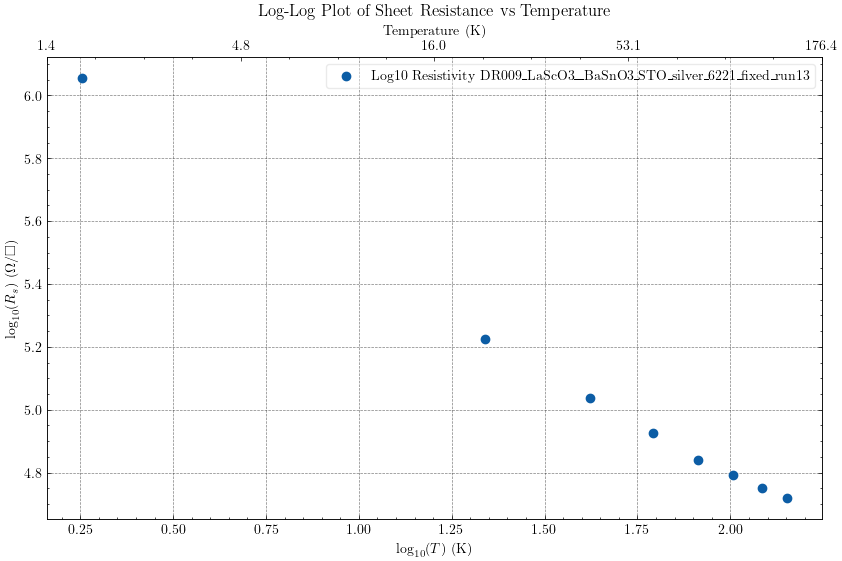

In [17]:
# Create a figure and axis
fig9 = plt.figure(figsize=(10, 6))
ax = fig9.add_subplot(111)  # Create a single subplot

# Loop over the data sets
for j, d in enumerate(dat):
    # Plot log10(rho_film) vs log10(Temp)
    ax.scatter(np.log10(d.res_data[int(d.ctf[5]/2)::d.ctf[5], 0]), np.log10(d.res_data[int(d.ctf[5]/2)::d.ctf[5], 4]), marker='o', linestyle='-', label=f'Log10 Resistivity {d.filename}')


# Set labels and title for either sheet resistance or resistivity
ax.set_xlabel(r'$\log_{10}(T)$ (K)')
ax.set_title(r'Arrhenius Plot at H = 0 kOe')
if dat[0].film_thickness == 1:
    ax.set_ylabel(r'$\log_{10}(R_s)$ ($\Omega/ \square$)')
    ax.set_title(r'Log-Log Plot of Sheet Resistance vs Temperature')
else:
    ax.set_ylabel(r'$\log_{10}(\rho)$ ($\Omega \cdot m$)')
    ax.set_title(r'Log-Log Plot of Resistivity vs Temperature')


# Add lines of n=1 and n=2 with best fit intercepts
x_vals = np.linspace(np.log10(min_temp), np.log10(max_temp), 100)

# Calculate the best fit intercept for n=1
for j, d in enumerate(dat):
    log_T = np.log10(d.res_data[int(d.ctf[5]/2)::d.ctf[5], 0])
    log_R = np.log10(d.res_data[int(d.ctf[5]/2)::d.ctf[5], 4])
    
    # slope_1 = 1
    # intercept_1 = np.mean(log_R - slope_1 * log_T)
    # ax.plot(x_vals, slope_1 * x_vals + intercept_1, label=f'n=1 (fit {d.filename})', linestyle='--', color='r')

    #slope_2 = 2
    #intercept_2 = np.mean(log_R - slope_2 * log_T)
    #ax.plot(x_vals, slope_2 * x_vals + intercept_2, label=f'n=2 (fit {d.filename})', linestyle='--', color='b')

# Add a grid
ax.grid(True)

# Add a legend
ax.legend(loc='best', framealpha=0.4)

# Create a secondary x-axis at the top
ax2 = ax.twiny()

# Set the limits of the secondary x-axis to match the primary x-axis
ax2.set_xlim(ax.get_xlim())

# Set the ticks and labels for the secondary x-axis
log_ticks = np.linspace(ax.get_xlim()[0], ax.get_xlim()[1], num=5)
ax2.set_xticks(log_ticks)
ax2.set_xticklabels([f'{10**tick:.1f}' for tick in log_ticks])
ax2.set_xlabel('Temperature (K)')

# Disable grid lines for the secondary x-axis
ax2.grid(False)

# Show the plot
plt.show()

if plot_data == True:
    fig9.savefig(dat[0].directory.joinpath(f'{dat[0].plot_str}_LogR_vs_LogT.{fig_format}'), dpi=300, bbox_inches='tight', transparent=plot_transparency)

## Plot IV Data to check linearity of Hall measurements

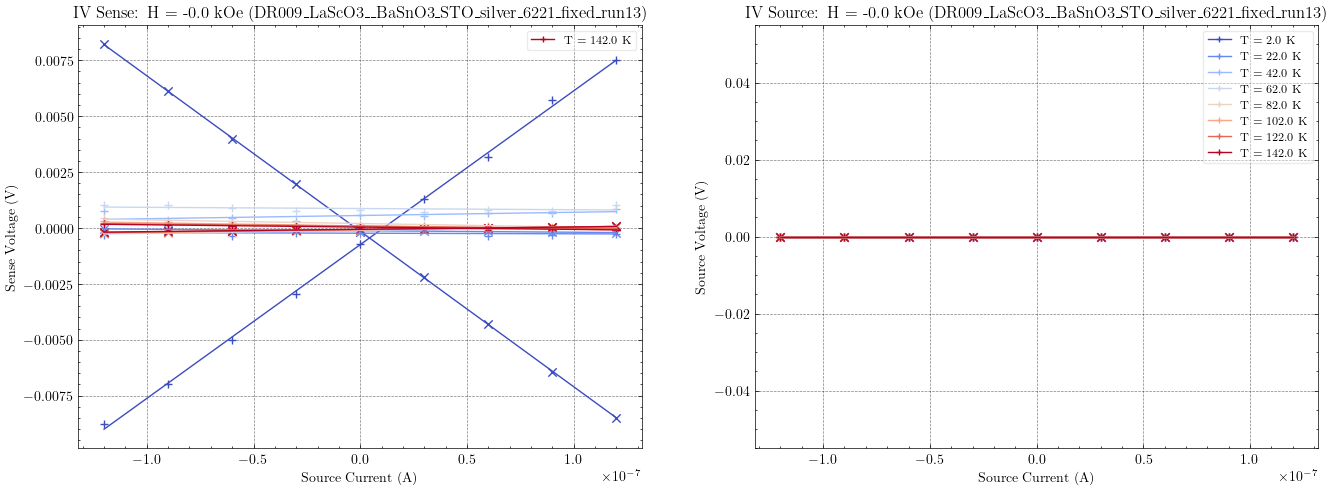

In [18]:
fig10 = plt.figure(figsize=(16, 5.5*len(dat)))
gs = fig10.add_gridspec(len(dat), 2)
labels = ['index_1', 'index_2']
color_s = ['r', 'g', 'b', 'm'] # simple four colors for the 4 configurations of vdp

for j, d in enumerate(dat):
    
    ax = fig10.add_subplot(gs[j, 0])
    ax1 = fig10.add_subplot(gs[j, 1])

    ## Plotting Source(I) vs Sense(V) data
    for t in range(d.ctf[4]):
        counter = t*d.ctf[3]*d.ctf[5] 
        for i in range(2):  
            R_test = linregress(d.data_np[counter:d.ctf[3]+counter, 2, i], d.data_np[counter:d.ctf[3]+counter, 4, i])
            ax.scatter(d.data_np[counter:d.ctf[3]+counter, 2, i], d.data_np[counter:d.ctf[3]+counter, 4, i], color=cmap_temp(norm_temp(d.ctf[1][t])), marker=mark_p[i])
            ax.plot(d.data_np[counter:d.ctf[3]+counter, 2, i], R_test.intercept + R_test.slope * d.data_np[counter:d.ctf[3]+counter, 2, i], color=cmap_temp(norm_temp(d.ctf[1][t])))

    # Add a dummy plot for the legend entry
    ax.plot([], [], marker = mark_p[j], color=cmap_temp(norm_temp(d.ctf[1][t])), label=f'T = {d.ctf[1][t]} K')

    ax.legend(loc='best', fontsize='small', markerscale=0.8, framealpha=0.4)

    # Set labels and title
    ax.set_xlabel('Source Current (A)')
    ax.set_ylabel('Sense Voltage (V)')
    ax.set_title(f'IV Sense: H = {np.round(d.data_np[0, 1, 2],decimals=0)*10} kOe ({d.filename})')


    ## Plotting the Source IV data
    for t_count in range(d.ctf[4]):
        counter = t_count*d.ctf[3]*d.ctf[5] 
        for i in range(2):  
            R_test_2 = linregress(d.data_np[counter:d.ctf[3]+counter, 2, i], d.data_np[counter:d.ctf[3]+counter, 3, i])
            ax1.scatter(d.data_np[counter:d.ctf[3]+counter, 2, i], d.data_np[counter:d.ctf[3]+counter, 3, i], color=cmap_temp(norm_temp(d.ctf[1][t_count])), marker=mark_p[i])
            ax1.plot(d.data_np[counter:d.ctf[3]+counter, 2, i], R_test_2.intercept + R_test_2.slope * d.data_np[counter:d.ctf[3]+counter, 2, i], color=cmap_temp(norm_temp(d.ctf[1][t_count])))
        # Add a dummy plot for the legend entry
        ax1.plot([], [], marker = mark_p[j], color=cmap_temp(norm_temp(d.ctf[1][t_count])), label=f'T = {d.ctf[1][t_count]} K')
        
        ax1.legend(loc='best', fontsize='small', markerscale=0.8, framealpha=0.4)

    # Set labels and title
    ax1.set_xlabel('Source Current (A)')
    ax1.set_ylabel('Source Voltage (V)')
    ax1.set_title(f'IV Source: H = {np.round(d.data_np[0, 1, 2],decimals=0)*10} kOe ({d.filename})')

    #ax.set_ylim(-0.00005,0.00005)

plt.show()

if plot_data == True:
    fig10.savefig(dat[0].directory.joinpath(f'{dat[0].plot_str}_IV_resistivity.{fig_format}'), dpi=300, bbox_inches='tight', transparent=plot_transparency)


## R-squared Analysis to Check Linearity of Hall I-V data

average R-squared_A for DR009_LaScO3__BaSnO3_STO_silver_6221_fixed_run13 = 0.7323709827093532
average R-squared_B for DR009_LaScO3__BaSnO3_STO_silver_6221_fixed_run13 = 0.9947608939840911


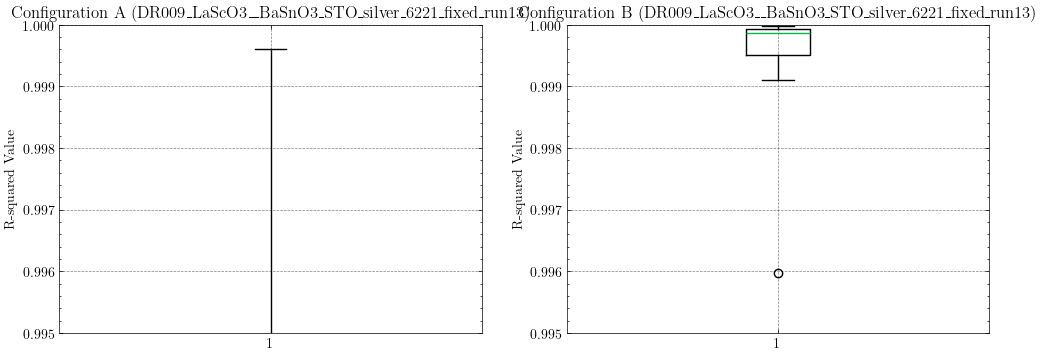

In [19]:
for d in dat:
    print(f'average R-squared_A for {d.filename} =', np.mean(np.abs(d.hall_data[:, 3])))
    print(f'average R-squared_B for {d.filename} =', np.mean(np.abs(d.hall_data[:, 5])))

    # Plot R-square values in a boxplot
    # Note that the y axis is showing the deviation in 1e-6 from the perfect value of 1 so generally the values are very close to 1
    fig11 = plt.figure(figsize=(12, 4))
    ax = fig11.add_subplot(121)
    ax.boxplot(np.abs(d.hall_data[:, 3]))
    ax.set_title(f'Configuration A ({d.filename})')
    ax.set_ylabel('R-squared Value')
    ax.set_ylim(1-5e-3, 1)  # If needed, you can set x-axis limits too

    ax2 = fig11.add_subplot(122)
    ax2.boxplot(np.abs(d.hall_data[:, 5]))
    ax2.set_title(f'Configuration B ({d.filename})')
    ax2.set_ylabel('R-squared Value')
    ax2.set_ylim(1-5e-3, 1)  # If needed, you can set x-axis limits too
    plt.show()

    if plot_data == True:
        fig11.savefig(dat[0].directory.joinpath(f'{dat[0].plot_str}_R_squared_hall_res.{fig_format}'), dpi=300, bbox_inches='tight', transparent=plot_transparency)


## Hall Resistivity ($\rho_{xy}$)
- This is: $\rho_{xy} = \frac{V_{measured-perpendicular}}{I_{source}}*t$
- Define: $Rsheet_{xy} = \frac{V_{measured-perpendicular}}{I_{source}}$ = $\frac{\rho_{xy}}{t}$


## Hall resisitivity vs Temperature

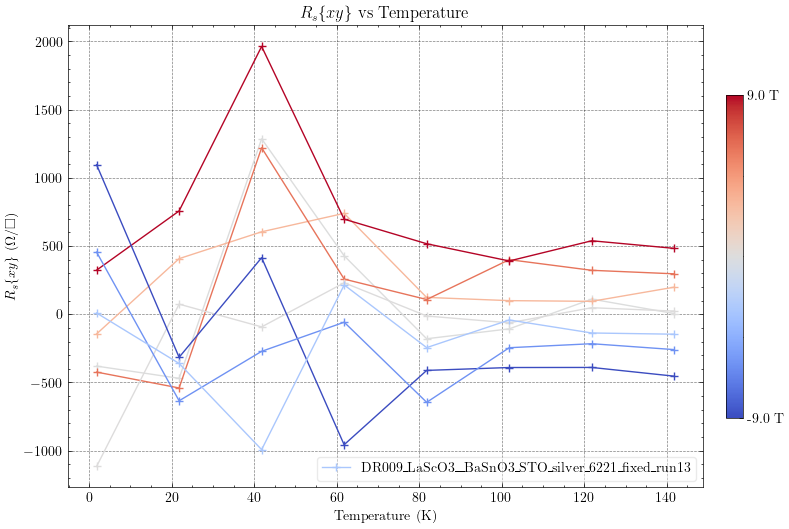

In [20]:
# Create a figure and axis
fig12 = plt.figure(figsize=(10, 6))
ax = fig12.add_subplot(111)  # Create a single subplot


for j, d in enumerate(dat):
    # Generating one set of colors for increasing positive field and one set for decreasing negative field
    # higher field is brighter color in both cases
    cmap1 = plt.get_cmap('winter')(np.linspace(0, 1, int(d.ctf[5] / 2)))
    cmap2 = plt.get_cmap('winter_r')(np.linspace(0, 0.8, int(d.ctf[5] / 2)))
    c_val = np.vstack((cmap1, cmap2))

    
    for k in range(d.ctf[5]):
        # Plot rho_film vs Temp
        ax.plot(d.hall_data[k::d.ctf[5], 0], d.hall_data[k::d.ctf[5], 6] * unit_scale, marker=mark_p[j], color= cmap_field(norm_field(d.hall_data[k, 1])))

    # Add a dummy plot for the legend entry
    ax.plot([], [], marker = mark_p[j], color = cmap_field(norm_field(d.hall_data[k, 1])), label=f'{d.filename}')
        
        
        
# Set labels and title for either sheet resistance or resistivity
ax.set_xlabel('Temperature (K)')
if dat[0].film_thickness == 1:

    ax.set_ylabel(r'$R_{s}\{xy\}$ ($\Omega/\square$)')
    ax.set_title(r'$R_{s}\{xy\}$ vs Temperature')

elif ohm_m == 1:
    ax.set_ylabel(r'Resistivity ($\Omega \cdot$m)')
    ax.set_title(r'$\rho_{xy}$ vs Temperature')

else:
    ax.set_ylabel(r'$\rho_{xy}\,(\mu \Omega \cdot cm)$')
    ax.set_title(r'$\rho_{xy}$ vs Temperature')
# Set labels and title


# ax.set_xlim(0,100)
# ax.set_ylim(1425,1525)

# Add a grid
ax.grid(True)

# Add a legend
ax.legend(loc='lower right', framealpha=0.4)

# Create a ScalarMappable and add a colorbar
sm = ScalarMappable(cmap=cmap_field, norm=norm_field)
cbar = plt.colorbar(sm, ax=ax,  pad=0.03, shrink=0.7)
cbar.set_ticks([min_field, max_field])
cbar.set_ticklabels([f'{min_field:.1f} T', f'{max_field:.1f} T'])

# Show the plot
#ax.set_ylim(-10000,10000)
plt.show()

if plot_data == True:
    fig12.savefig(dat[0].directory.joinpath(f'{dat[0].plot_str}_rho_xy_vs_T.{fig_format}'), dpi=300, bbox_inches='tight', transparent=plot_transparency)


## Hall Resistivity vs Field

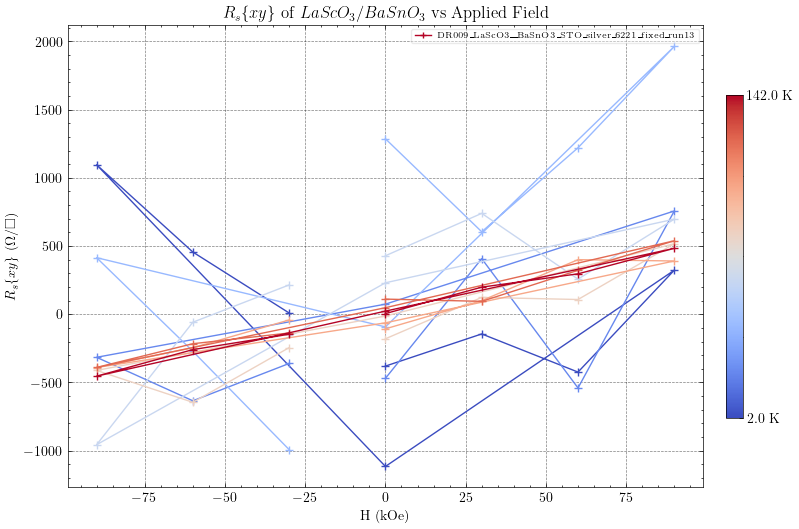

In [21]:
# Create a figure and axis
fig13 = plt.figure(figsize=(10, 6))
ax = fig13.add_subplot(111)  # Create a single subplot

# Loop over the data sets
for j, d in enumerate(dat):
    # Generating one set of colors for increasing positive field and one set for decreasing negative field
    # higher field is brighter color in both cases
    c_val = plt.get_cmap('winter')(np.linspace(0, 1, int(d.ctf[5])))

    for t_count, t_val in enumerate(d.ctf[1], start=0):
        index = t_count * d.ctf[5]
        t = d.hall_data[index, 0]
        # Plot rho_film vs Temp
        ax.plot(d.hall_data[index:index+d.ctf[5], 1]*10, d.hall_data[index:index+d.ctf[5], 6]*unit_scale, marker=mark_p[j], color=cmap_temp(norm_temp(t)))
        
    # Add a dummy plot for the legend entry
    ax.plot([], [], marker = mark_p[j], color = cmap_temp(norm_temp(t)), label=f'{d.filename}')


# Set labels and title for either sheet resistance or resistivity
ax.set_xlabel('H (kOe)')
if dat[0].film_thickness == 1:

    ax.set_ylabel(r'$R_{s}\{xy\}$ ($\Omega/\square$)')
    ax.set_title(r'$R_{s}\{xy\}$' f' of {d.material} vs Applied Field')
    
elif ohm_m == 1:
    ax.set_ylabel(r'$\rho_{xy}\, ($\Omega \cdot$m)')
    ax.set_title(r'$\rho_{xy}$' f' of {d.material} vs Applied Field')
    
else:
    ax.set_ylabel(r'$\rho_{xy}\,(\mu \Omega \cdot cm)$')
    ax.set_title(r'$\rho_{xy}$' f' of {d.material} vs Applied Field')
    

# Add a grid
ax.grid(True)

# Add a legend
ax.legend(loc='best', framealpha=0.4, markerscale=0.8, fontsize='xx-small')

# Create a ScalarMappable and add a colorbar
sm = ScalarMappable(cmap=cmap_temp, norm=norm_temp)
cbar = plt.colorbar(sm, ax=ax,  pad=0.03, shrink=0.7)
#cbar.set_label('Temperature (K)')
cbar.set_ticks([min_temp, max_temp])
cbar.set_ticklabels([f'{min_temp:.1f} K', f'{max_temp:.1f} K'])

#ax.set_ylim(-10,10)
# Show the plot
plt.show()

if plot_data == True:
    fig13.savefig(dat[0].directory.joinpath(f'{dat[0].plot_str}_rho_xy_vs_field.{fig_format}'), dpi=300, bbox_inches='tight', transparent=plot_transparency)


## Hall Resistivity vs Field Configuration A vs B
- Dotted line vs solid line is B vs A

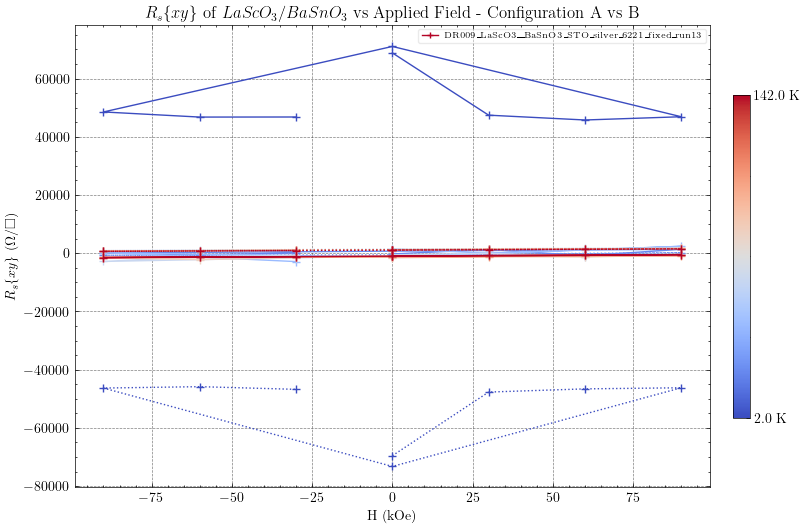

In [22]:
# Create a figure and axis
fig14 = plt.figure(figsize=(10, 6))
ax = fig14.add_subplot(111)  # Create a single subplot

# Create a secondary y-axis
#ax2 = ax.twinx()

# Loop over the data sets
for j, d in enumerate(dat, start=0):
    # Generating one set of colors for increasing positive field and one set for decreasing negative field
    # higher field is brighter color in both cases
    c_val = plt.get_cmap('winter')(np.linspace(0, 1, d.ctf[4]))



    for t_count, t in enumerate(d.ctf[1], start=0):
        if t > 1:
            index = t_count * d.ctf[5]
            # Plot rho_film vs Temp
            ax.plot(d.hall_data[index:index+d.ctf[5], 1]*10, (d.hall_data[index:index+d.ctf[5], 2])*unit_scale, marker=mark_p[j], color=cmap_temp(norm_temp(t)))
            ax.plot(d.hall_data[index:index+d.ctf[5], 1]*10, (d.hall_data[index:index+d.ctf[5], 4])*unit_scale, marker=mark_p[j], color=cmap_temp(norm_temp(t)), linestyle=':')
            #ax2.plot(d.ctf[2][:] * 10, d.mag_res[t_count, :, 2], color=cmap_temp(norm_temp(t)), linestyle=':')
    # Add a dummy plot for the legend entry
    ax.plot([], [], marker = mark_p[j], color = cmap_temp(norm_temp(t)), label=f'{d.filename}')


# Set labels and title for either sheet resistance or resistivity
ax.set_xlabel('H (kOe)')
if dat[0].film_thickness == 1:

    ax.set_ylabel(r'$R_{s}\{xy\}$ ($\Omega/\square$)')
    ax.set_title(r'$R_{s}\{xy\}$' f' of {d.material} vs Applied Field - Configuration A vs B')
    
elif ohm_m == 1:
    ax.set_ylabel(r'Resistivity ($\Omega \cdot$m)')
    ax.set_title(r'$\rho_{xy}$' f' of {d.material} vs Applied Field - Configuration A vs B')
    
else:
    ax.set_ylabel(r'$\rho_{xy}\,(\mu \Omega \cdot cm)$')
    ax.set_title(r'$\rho_{xy}$' f' of {d.material} vs Applied Field - Configuration A vs B')
    

# Add a grid
ax.grid(True)

# Add a legend
ax.legend(loc='best', framealpha=0.4, markerscale=0.8, fontsize='xx-small')

# Create a ScalarMappable and add a colorbar
sm = ScalarMappable(cmap=cmap_temp, norm=norm_temp)
cbar = plt.colorbar(sm, ax=ax,  pad=0.03, shrink=0.7)
#cbar.set_label('Temperature (K)')
cbar.set_ticks([min_temp, max_temp])
cbar.set_ticklabels([f'{min_temp:.1f} K', f'{max_temp:.1f} K'])

#ax.set_ylim(-200, 200)

# Show the plot
plt.show()

if plot_data == True:
    fig14.savefig(dat[0].directory.joinpath(f'{dat[0].plot_str}_rho_xy_vs_field_AvsB.{fig_format}'), dpi=300, bbox_inches='tight', transparent=plot_transparency)


## Hall Resistivity ($\rho_{xy}$)
- This is: $\rho_{xy} = \frac{V_{measured-perpendicular}}{I_{source}}*t = \frac{B}{n\times e}$
- Or $Rsheet_{xy} = \frac{V_{measured-perpendicular}}{I_{source}}$ = $\frac{\rho_{xy}}{t}$

#### Step 1
- $V_H = \frac{I\times B}{n\times e\times t}$
- $V_H = (\frac{\rho_{xy}}{t})\times I = M_1\times I$ 
- $M_1$ (first gradient) = $\frac{\rho_{xy}}{t}$

#### Step 2
- $\rho_{xy} = \frac{1}{n\times e}\times B = M_2*B$
- $M_2 = R_H = \frac{1}{n\times e}$ = gradient of $\rho_{xy}$ vs B
- $n = \frac{1}{M_2 \times e} = \frac{1}{R_H \times e}$
- $\mu = \frac{1}{n\times e \times \rho_{xy}} = \frac{M_2}{\rho_{xy}} = \frac{R_H}{ \rho_{xy}}$

## 2DEG Case
- no longer inputting a t as it is unphysical
- $R_{sheet} = \frac{\rho_{xy}}{t}$
- $n_{2D} = n\times t$

#### Step 1
- $V_H = \frac{I\times B}{n\times e\times t}$
- $V_H = (\frac{\rho_{xy}}{t})\times I = M_1\times I$ 
- $M_1$ (first gradient) = $\frac{\rho_{xy}}{t}$

#### Step 2
- $\rho_{xy} = \frac{1}{n\times e}\times B$ ---> $M_1 = \frac{\rho_{xy}}{t} = \frac{1}{n\times e \times t}\times B = M_2*B$
- $M_2 = \frac{R_H}{t} = \frac{1}{n\times e \times t}$ 
- $n_{2D} = n\times t = \frac{1}{M_2 \times e} = \frac{1}{R_H \times e}$
- $\mu = \frac{1}{n\times e \times \rho_{xy}} = \frac{1}{\frac{n_{2d}}{t}\times e \times (\R_{sheet}\times t)} = \frac{1}{n_{2d}\times e \times \R_{sheet}} = \frac{M_2}{\R_{sheet}} = \frac{R_H}{ \rho_{xy}}$

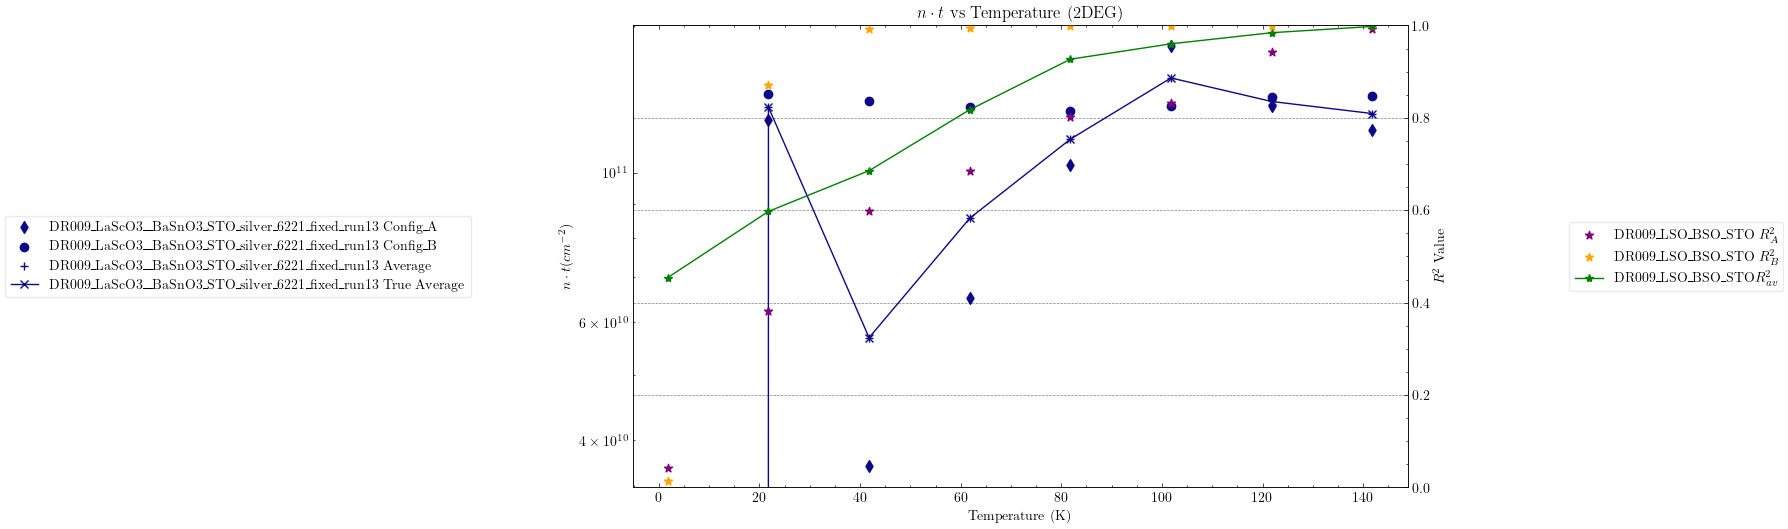

In [23]:
# Create a figure and axis
fig15 = plt.figure(figsize=(10, 6))
ax = fig15.add_subplot(111)  # Create a single subplot


# Create separate marker arrays for positive and negative fields stitched together
marker_hall = ['x', 'o', '*']

for j, d in enumerate(dat):
    ax.scatter(d.hall_coefficient[:, 0], 1e-6 * np.divide(1, np.multiply(d.hall_coefficient[:, 1], scipy.constants.e)), marker='d', color=cmap_dat[j], label=f'{d.filename} Config_A')
    ax.scatter(d.hall_coefficient[:, 0], 1e-6 * np.divide(1, np.multiply(d.hall_coefficient[:, 3], scipy.constants.e)), marker='o', color=cmap_dat[j], label=f'{d.filename} Config_B')
    ax.scatter(d.hall_coefficient[:, 0], 1e-6 * np.divide(1, np.multiply(d.hall_coefficient[:, 5], scipy.constants.e)), marker='+', color=cmap_dat[j], label=f'{d.filename} Average')
    ax.plot(d.hall_coefficient[:, 0], 1e-6 * np.divide(1, np.multiply(d.hall_coefficient[:, 5], scipy.constants.e)), marker='x', color=cmap_dat[j], label=f'{d.filename} True Average')
    # 1e-6 to convert from m^-3 to cm^-3

# Set labels and title for either sheet resistance or resistivity
ax.set_xlabel('Temperature (K)')
if dat[0].film_thickness == 1:
    ax.set_ylabel(r'$n\cdot t$' r'($cm^{-2}$)')
    ax.set_title(r'$n\cdot t$ vs Temperature (2DEG)')
else:
    ax.set_ylabel(r'n($cm^{-3}$)')
    ax.set_title(r'Charge Carrier Density vs Temperature')  
    

# Add a grid
ax.grid(False)


# Add a legend for the left y-axis
ax.legend(loc='center right', bbox_to_anchor=(-0.2, 0.5), framealpha=0.4)

# Create a second y-axis on the right
ax2 = ax.twinx()

# Plot data on the right y-axis
for j, d in enumerate(dat):
    ax2.scatter(d.hall_coefficient[:, 0], np.abs(d.hall_coefficient[:, 2]), color='purple', marker='*', label=f'{d.plot_str} $R^2_A$')
    ax2.scatter(d.hall_coefficient[:, 0], np.abs(d.hall_coefficient[:, 4]), color='orange', marker='*', label=f'{d.plot_str} $R^2_B$')
    ax2.plot(d.hall_coefficient[:, 0], np.abs(d.hall_coefficient[:, 7]), color='green', marker='*', label=f'{d.plot_str}' r'$R^2_{av}$')
    

# Set labels for the right y-axis
ax2.set_ylabel('$R^2$ Value')

# Add a legend for the right y-axis
ax2.legend( loc='center left', bbox_to_anchor=(1.2, 0.5), framealpha=0.4)
ax2.set_ylim(0, 1)

#ax.set_ylim(0,5e14)
ax.set_yscale('log')

# Show the plot
plt.show()

if plot_data == True:
    fig15.savefig(dat[0].directory.joinpath(f'{dat[0].plot_str}_n_vs_temperature.{fig_format}'), dpi=300, bbox_inches='tight', transparent=plot_transparency)


## Mobility vs T

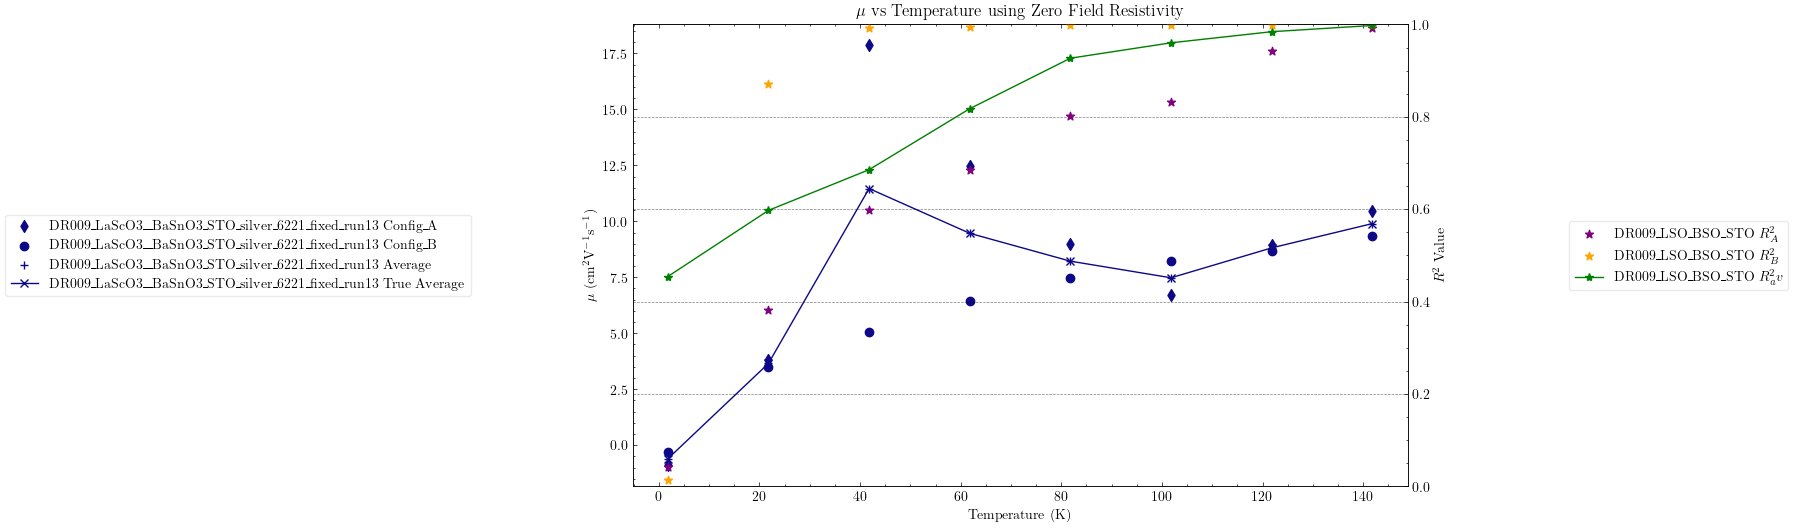

In [24]:
# Create a figure and axis
fig16 = plt.figure(figsize=(10, 6))
ax = fig16.add_subplot(111)  # Create a single subplot


for j, d in enumerate(dat, start=0):
    ax.scatter(d.hall_coefficient[:, 0], 1e4 * np.divide(d.hall_coefficient[:, 1], d.res_data[int(d.ctf[5]/2-1)::d.ctf[5], 4]), marker='d', color=cmap_dat[j], label=f'{d.filename} Config_A')
    ax.scatter(d.hall_coefficient[:, 0], 1e4 * np.divide(d.hall_coefficient[:, 3], d.res_data[int(d.ctf[5]/2-1)::d.ctf[5], 4]), marker='o', color=cmap_dat[j], label=f'{d.filename} Config_B')
    ax.scatter(d.hall_coefficient[:, 0], 1e4 * np.divide(d.hall_coefficient[:, 5], d.res_data[int(d.ctf[5]/2-1)::d.ctf[5], 4]), marker='+', color=cmap_dat[j], label=f'{d.filename} Average')
    ax.plot(d.hall_coefficient[:, 0], 1e4 * np.divide(d.hall_coefficient[:, 6], d.res_data[int(d.ctf[5]/2-1)::d.ctf[5], 4]), marker='x', color=cmap_dat[j], label=f'{d.filename} True Average')
    
# Set labels and title for the left y-axis
ax.set_xlabel('Temperature (K)')
ax.set_ylabel(r'$\mu$ (cm$^2$V$^{-1}$s$^{-1}$)')
ax.set_title(r'$\mu$' f' vs Temperature using Zero Field Resistivity')
#ax.set_ylim(-100, 0)

# Add a grid
ax.grid(False)

# Add a legend for the left y-axis
ax.legend(loc='center right', bbox_to_anchor=(-0.2, 0.5), framealpha=0.4)

# Create a second y-axis on the right
ax2 = ax.twinx()

# Plot data on the right y-axis
for d in dat:
    ax2.scatter(d.hall_coefficient[:, 0], np.abs(d.hall_coefficient[:, 2]), color='purple', marker='*', label=f'{d.plot_str} $R^2_A$')
    ax2.scatter(d.hall_coefficient[:, 0], np.abs(d.hall_coefficient[:, 4]), color='orange', marker='*', label=f'{d.plot_str} $R^2_B$')
    ax2.plot(d.hall_coefficient[:, 0], np.abs(d.hall_coefficient[:, 7]), color='green', marker='*', label=f'{d.plot_str} $R^2_av$')

# Set labels for the right y-axis
ax2.set_ylabel('$R^2$ Value')

# Add a legend for the right y-axis
ax2.legend(loc='center left', bbox_to_anchor=(1.2, 0.5), framealpha=0.4)
ax2.set_ylim(0, 1)

#ax.set_xlim(0,20)
#ax.set_yscale('log')

# Show the plot
plt.show()

if plot_data == True:
    fig16.savefig(dat[0].directory.joinpath(f'{dat[0].plot_str}_mobility_vs_temperature.{fig_format}'), dpi=300, bbox_inches='tight', transparent=plot_transparency)


## Mobility and Charge Carrier Density

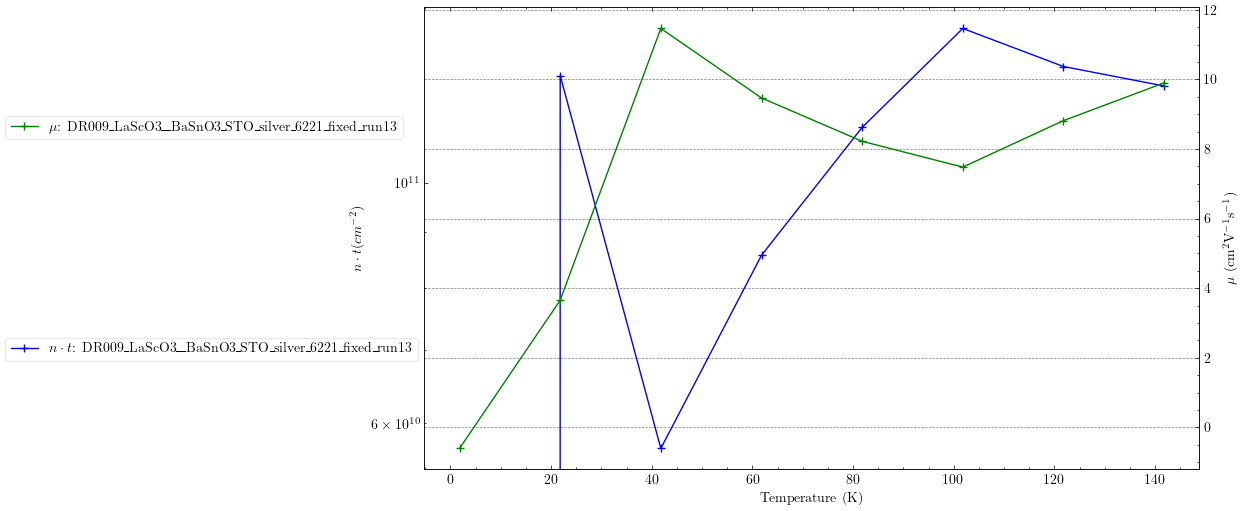

In [25]:
# Create a figure and axis
fig17 = plt.figure(figsize=(10, 6))
ax = fig17.add_subplot(111)  # Create a single subplot

# Set labels and title for either sheet resistance or resistivity
ax.set_xlabel('Temperature (K)')
if dat[0].film_thickness == 1:
    ax.set_ylabel(r'$n\cdot t$' r'($cm^{-2}$)')
    
    # set a label to pass as a prefix to the plot string
    n_label = r'$n\cdot t$: '
    #ax.set_title(r'$n\cdot t$ vs Temperature (2DEG)')
else:
    ax.set_ylabel(r'n($cm^{-3}$)')
    # set a label to pass as a prefix to the plot string
    n_label = r'$n$: '
    #ax.set_title(r'Charge Carrier Density vs Temperature') 
    
    

for j, d in enumerate(dat):
    
    ax.plot(d.hall_coefficient[:, 0], 1e-6 * np.divide(1, np.multiply(d.hall_coefficient[:, 5], scipy.constants.e)), marker=mark_p[j], color='blue', label=f'{n_label}{d.filename}') 
    

# Add a grid
ax.grid(False)


# Add a legend for the left y-axis
ax.legend(loc='upper left', bbox_to_anchor=(-0.55, 0.3), framealpha=0.4)

# Create a second y-axis on the right
ax2 = ax.twinx()

# Plot data on the right y-axis
for j, d in enumerate(dat, start=0):

    ax2.plot(d.hall_coefficient[:, 0], 1e4 * np.divide(d.hall_coefficient[:, 6], d.res_data[int(d.ctf[5]/2-1)::d.ctf[5], 4]), marker=mark_p[j], color='green', label=r'$\mu$'f': {d.filename}' )
    

# Set labels for the right y-axis
ax2.set_ylabel(r'$\mu$ (cm$^2$V$^{-1}$s$^{-1}$)')

# Add a legend for the right y-axis
ax2.legend( loc='lower left', bbox_to_anchor=(-0.55, 0.7), framealpha=0.4)


#ax2.set_ylim(0,20)
ax.set_yscale('log')

# Show the plot
plt.show()

if plot_data == True:
    fig17.savefig(dat[0].directory.joinpath(f'{dat[0].plot_str}_n_u_vs_temperature.{fig_format}'), dpi=300, bbox_inches='tight', transparent=plot_transparency)


## $\rho_{xy}$ vs $\rho_{xx}$
- Can have problems where with both holes and electrons the carriers can cancel out the measured hall voltage
- Need to check this?

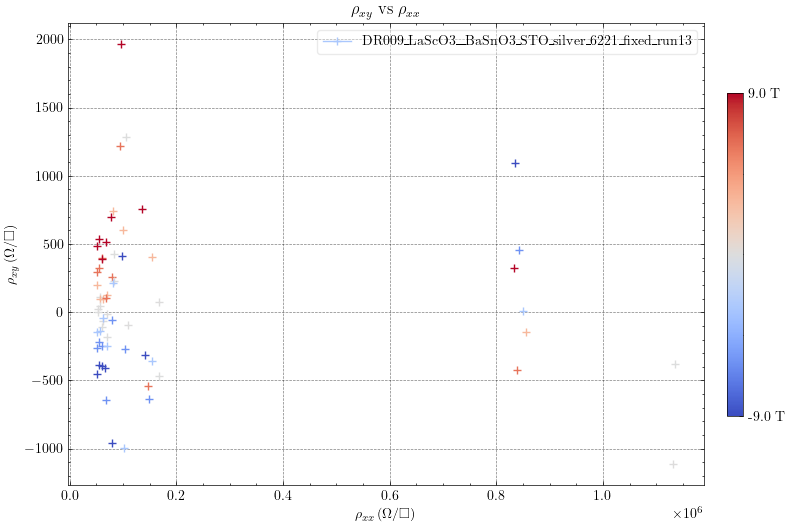

In [26]:
# Create a figure and axis
fig18 = plt.figure(figsize=(10, 6))
ax = fig18.add_subplot(111)  # Create a single subplot

# Loop over the data sets
for j, d in enumerate(dat, start=0):
    # Generate color map
    c_val = plt.get_cmap('winter')(np.linspace(0, 1, d.ctf[5]))


    for H_count, H in enumerate(d.ctf[2], start=0):
        # Plot rho_film vs Temp
        ax.scatter(d.res_data[H_count::d.ctf[5], 4] * unit_scale, d.hall_data[H_count::d.ctf[5], 6] * unit_scale, marker=mark_p[j], color=cmap_field(norm_field(H)))

    # Add a dummy plot for the legend entry
    ax.plot([], [], marker = mark_p[j], color = cmap_field(norm_field(H)), label=f'{d.filename}')

ax.set_title(r'$\rho_{xy}$ vs $\rho_{xx}$')
if dat[0].film_thickness == 1:
    ax.set_ylabel(r'$\rho_{xy}\,(\Omega/\square)$')
    ax.set_xlabel(r'$\rho_{xx}\,(\Omega/\square)$')

elif ohm_m == 1:
    ax.set_ylabel(r'$\rho_{xy}\,(\Omega \cdot m)$')
    ax.set_xlabel(r'$\rho_{xx}\,(\Omega \cdot m)$')
    
else:
    ax.set_ylabel(r'$\rho_{xy}\,(\mu \Omega \cdot cm)$')
    ax.set_xlabel(r'$\rho_{xx}\,(\mu \Omega \cdot cm)$')

# Add a grid
ax.grid(True)

# Add a legend
ax.legend(loc='best', framealpha=0.4)

# Create a ScalarMappable and add a colorbar
sm = ScalarMappable(cmap=cmap_field, norm=norm_field)
cbar = plt.colorbar(sm, ax=ax,  pad=0.03, shrink=0.7)
cbar.set_ticks([min_field, max_field])
cbar.set_ticklabels([f'{min_field:.1f} T', f'{max_field:.1f} T'])

# Show the plot
plt.show()

if plot_data == True:
    fig18.savefig(dat[0].directory.joinpath(f'{dat[0].plot_str}_rho_xx_vs_rho_xy.{fig_format}'), dpi=300, bbox_inches='tight', transparent=plot_transparency)


##  Shubnikov–de Haas (SdH) oscillations

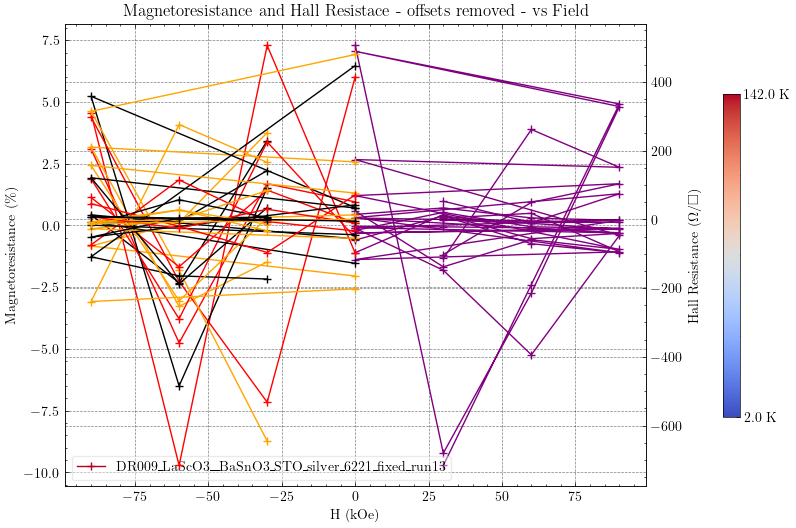

In [27]:
fig19 = plt.figure(figsize=(10, 6 ))
gs = fig19.add_gridspec(1, 1)
ax = fig19.add_subplot(gs[0, 0])

ax2 = ax.twinx()

for j, d in enumerate(dat):
    for t_count, t_val in enumerate(d.ctf[1], start=0):  
        if t_val > 1:
            ### Fitting to MR data
            # Perform a quadratic fit on the Magnetoresistance data
            #tf = [current_unique, temp_unique, field_unique, current_no, temp_no, field_no]
            x_data_MR = d.tf_av[t_count*d.ctf[5]:(t_count+1)*d.ctf[5],1] * 10
            # Get modulus of x_data_MR
            x_data_MR = np.abs(x_data_MR)
            y_data_MR = d.mag_res[t_count, :, 2]
            coeffs_MR = np.polyfit(x_data_MR, y_data_MR, 1)
            polynomial_fit_MR = np.polyval(coeffs_MR, x_data_MR)

            # Plot the original MR data and the quadratic fit
            #ax.scatter(x_data_MR, y_data_MR, marker=mark_p[j], color='green')  # initial MR data
            #ax.plot(x_data_MR, polynomial_fit_MR, color='blue')  # quadratic fit to MR data
            ax.plot(x_data_MR, y_data_MR - polynomial_fit_MR, marker=mark_p[j], color='purple')  # Residual MR


            ### Fitting to Hall data
            index = t_count * d.ctf[5]
            
            
            # Extract the positive and negative applieed B of the Hall data
            x_data_Hall_neg = d.hall_data[index: int(index + d.ctf[5] / 2), 1] * 10
            y_data_Hall_neg = d.hall_data[index: int(index + d.ctf[5] / 2), 6] * unit_scale
            x_data_Hall_pos = d.hall_data[int(index + d.ctf[5] / 2): index + d.ctf[5], 1] * 10
            y_data_Hall_pos = d.hall_data[int(index + d.ctf[5] / 2): index + d.ctf[5], 6] * unit_scale

            # Perform a linear fit on the negative Hall data
            coeffs_Hall_neg = np.polyfit(x_data_Hall_neg, y_data_Hall_neg, 1)
            polynomial_fit_Hall_neg = np.polyval(coeffs_Hall_neg, x_data_Hall_neg)
            # Perform a linear fit on the positive Hall data
            coeffs_hall_pos = np.polyfit(x_data_Hall_pos, y_data_Hall_pos, 1)
            polynomial_fit_Hall_pos = np.polyval(coeffs_hall_pos, x_data_Hall_pos)
            
            y_data_Hall_neg_res = y_data_Hall_neg - polynomial_fit_Hall_neg
            #y_data_Hall_neg_res = scipy.signal.medfilt(y_data_Hall_neg_res, kernel_size=5)
            y_data_Hall_pos_res = y_data_Hall_pos - polynomial_fit_Hall_pos
            #y_data_Hall_pos_res = scipy.signal.medfilt(y_data_Hall_pos_res, kernel_size=5)
            
            # Plot the original Hall data and the polynomial fit
            # ax2.scatter(x_data_Hall_neg, y_data_Hall_neg, marker=mark_p[j], color='black')  # initial Hall data
            # ax2.plot(x_data_Hall_neg, polynomial_fit_Hall_neg, color='black')  # polynomial fit to Hall data
            # ax2.scatter(x_data_Hall_pos, y_data_Hall_pos, marker=mark_p[j], color='black')  # initial Hall data
            # ax2.plot(x_data_Hall_pos, polynomial_fit_Hall_pos, color='black')  # polynomial fit to Hall data
            
            ax2.plot(-x_data_Hall_neg, y_data_Hall_neg_res, marker=mark_p[j], color='red') # Residual Hall for negative field
            ax2.plot(x_data_Hall_pos, y_data_Hall_pos_res, marker=mark_p[j], color='orange') # Residual Hall for positive field
            ax2.plot(x_data_Hall_pos, (y_data_Hall_neg_res + y_data_Hall_pos_res)/2, marker=mark_p[j], color='black') # Average Residual Hall 
        
    
    # Add a dummy plot for the legend entry
    ax.plot([], [], marker = mark_p[j], color=cmap_temp(norm_temp(t_val)), label=f'{d.filename}')

        
ax.set_xlabel('H (kOe)')
ax.set_ylabel(r'Magnetoresistance (\%)')
ax.set_title(f'Magnetoresistance and Hall Resistace - offsets removed - vs Field')
ax.legend(loc='best', framealpha=0.4)

ax2.set_ylabel(r'Hall Resistance ($\Omega/\square$)')

# Create a ScalarMappable and add a colorbar
sm = ScalarMappable(cmap=cmap_temp, norm=norm_temp)
cbar = plt.colorbar(sm, ax=ax,  pad=0.1, shrink=0.7)
#cbar.set_label('Temperature (K)')
cbar.set_ticks([min_temp, max_temp])
cbar.set_ticklabels([f'{min_temp:.1f} K', f'{max_temp:.1f} K'])


#ax.set_xlim(60,90)
#ax.set_ylim(-10,10)
plt.show()

if plot_data == True:
    fig19.savefig(dat[0].directory.joinpath(f'{dat[0].plot_str}_SDH_oscillations.{fig_format}'), dpi=300, bbox_inches='tight', transparent=plot_transparency)


## SDH $\frac{-d^2R_{xx}}{dB^2}$

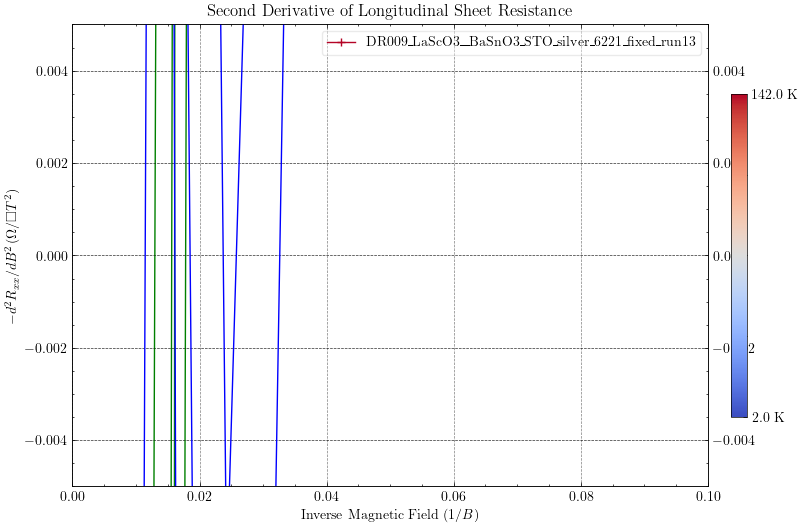

In [28]:
fig20 = plt.figure(figsize=(10, 6 ))
gs = fig20.add_gridspec(1, 1)
ax = fig20.add_subplot(gs[0, 0])
ax2 = ax.twinx()

for j, d in enumerate(dat):
    for t_count, t_val in enumerate(d.ctf[1], start=0):  
        if t > 1:
            
            index = t_count * d.ctf[5]
            ### Compute the second derivative of the longitudinal sheet resistance with respect to the magnetic field
            B_field = d.hall_data[index:index+d.ctf[5], 1] * 10 # Magnetic field
            
            Rsxx = d.res_data[t_count*d.ctf[5]:(t_count+1)*d.ctf[5], 4] # Sheet resistance
            
            # Get the indices that would sort B_field in ascending order
            sorted_indices = np.argsort(B_field)

            # Sort B_field and Rsxx using the sorted indices
            B_field_sorted = B_field#[sorted_indices]
            Rsxx_sorted = Rsxx#[sorted_indices]

            # Compute the first and second derivatives
            dRsxx_dB = np.gradient(Rsxx_sorted, B_field_sorted)
            d2Rsxx_dB2 = np.gradient(dRsxx_dB, B_field_sorted)
            

            ax.plot(1/B_field_sorted, -d2Rsxx_dB2, marker=mark_p[j], color='green')
            
            ### Compute the second derivative of the hall resistance with respect to the magnetic field
            index = t_count * d.ctf[5]
            Rsxy = d.hall_data[index:index+d.ctf[5], 6] 
            Rsxy_sorted = Rsxy[sorted_indices]
            
            # Compute the first and second derivatives
            dRsxy_dB = np.gradient(Rsxy_sorted, B_field_sorted)
            d2Rsxy_dB2 = np.gradient(dRsxy_dB, B_field_sorted)
            
            ax2.plot(1/B_field_sorted, -d2Rsxy_dB2, marker=mark_p[j], color='blue')


    
    # Add a dummy plot for the legend entry
    ax.plot([], [], marker = mark_p[j], color = cmap_temp(norm_temp(t_val)), label=f'{d.filename}')

        
ax.set_xlabel(r'Inverse Magnetic Field ($1/B$)')
ax.set_ylabel(r'$-d^2R_{xx}/dB^2 \, (\Omega/ \square T^2)$')
ax.set_title(r'Second Derivative of Longitudinal Sheet Resistance')
ax.legend(loc='best', framealpha=0.4)

# Create a ScalarMappable and add a colorbar
sm = ScalarMappable(cmap=cmap_temp, norm=norm_temp)
cbar = plt.colorbar(sm, ax=ax,  pad=0.03, shrink=0.7)
#cbar.set_label('Temperature (K)')
cbar.set_ticks([min_temp, max_temp])
cbar.set_ticklabels([f'{min_temp:.1f} K', f'{max_temp:.1f} K'])

ax.set_xlim(0, 0.1)
ax.set_ylim(-0.005, 0.005)
ax2.set_ylim(-0.005, 0.005)

plt.show()

if plot_data == True:
    fig20.savefig(dat[0].directory.joinpath(f'{dat[0].plot_str}_Second_Derivative_of_MR.{fig_format}'), dpi=300, bbox_inches='tight', transparent=plot_transparency)


## Powerpoint Export

In [29]:

if powerpoint_data == True:
    # Create a PowerPoint presentation object
    prs = Presentation()

    # Define a function to add a slide with a title and image
    def add_slide(prs, title, fig):
        slide_layout = prs.slide_layouts[5]  # Use a blank slide layout
        slide = prs.slides.add_slide(slide_layout)
        
        # Set background color with 40% transparency
        background = slide.background
        fill = background.fill
        fill.solid()
        fill.fore_color.rgb = RGBColor(200, 200, 200)

        # Add title with custom font
        title_shape = slide.shapes.title
        title_shape.text = title
        title_shape.text_frame.paragraphs[0].font.size = Pt(24)
        title_shape.text_frame.paragraphs[0].font.bold = True
        title_shape.text_frame.paragraphs[0].font.color.rgb = RGBColor(0, 0, 0)
        title_shape.text_frame.paragraphs[0].font.name = 'Arial'
        title_shape.text_frame.paragraphs[0].alignment = PP_ALIGN.CENTER

        # Save the figure as an image
        img_path = f"{title}.png"
        fig.savefig(img_path, dpi=300, bbox_inches='tight', transparent=True)

        
         # Calculate the left position to center the image
        slide_width = prs.slide_width
        image_width = Inches(8)
        left = (slide_width - image_width) / 2
        top = Inches(2)  # Position the figure lower down by 2 inches
        
        # Add the image to the slide
        pic = slide.shapes.add_picture(img_path, left, top, width=image_width)

    # List of figures and their corresponding titles
    figures = [
        (fig1, "Plot IV data from Resistivity Measurement to Check Linearity"),
        (fig2, "R-squared Analysis to Check Linearity of I-V Resistivity data"),
        (fig3, "Resistivity Configuration Compararison"),
        (fig4, "Resistivity vs Temperature"),
        (fig5, "Resistivity vs H"),
        (fig6, "Magnetoresistance vs H"),
        (fig7, "Magnetoresistance Vs T"),
        (fig8, "Arhenius Plot"),
        (fig9, "Log(R) vs Log(T)"),
        (fig10, "Plot IV data of Hall Measurement to Check Linearity"),
        (fig11, "R-squared Analysis to Check Linearity of Resistivity I-V data"),
        (fig12, "Hall resisitivity vs Temperature"),
        (fig13, "Hall resisitivity vs Applied Field"),
        (fig14, "Hall resisitivity vs Applied Field - Offset Removed"),
        (fig15, "Charge Carrier Density Vs T"),
        (fig16, "Mobility vs T"),
        (fig17, "Mobility and Charge Carrier Density vs T"),
        (fig18, "ρ_xy vs ρ_xx"),
        (fig19, "Shubnikov–de Haas Oscillations"),
        (fig20, "Second_Derivative_of_MR"),
        
        
        
    ]

    # Add each figure to the PowerPoint presentation
    for fig, title in figures:
        add_slide(prs, title, fig)

    # Save the PowerPoint presentation
    prs.save(dat[0].directory.joinpath(f'{dat[0].plot_str}_figures_final.pptx'))